In [ ]:
# pip install xgboost

In [1]:
# import necessary libraries
"""
量化交易框架 - 主程序 v2.0
功能：数据导入、清洗、因子挖掘、因子合成、因子筛选、模型训练、因果检验、
      样本外验证、风险管理、回测、可视化
"""

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

In [2]:
# ==================== 0. 沪深300成分股导出 ====================

import akshare as ak

df = ak.index_stock_cons(symbol="000300")

# 适配字段
code_col = "品种代码" if "品种代码" in df.columns else "成分券代码"
name_col = "品种名称" if "品种名称" in df.columns else "成分券名称"

out = df[[code_col, name_col]].copy()
out.columns = ["股票代码", "股票名称"]

# 纯6位
out["股票代码"] = out["股票代码"].astype(str).str.replace(r"\D", "", regex=True).str.zfill(6)

out.to_excel("沪深300成分股.xlsx", index=False)
print("导出完成：沪深300成分股.xlsx")

excel_path = "沪深300成分股.xlsx"

导出完成：沪深300成分股.xlsx


In [3]:
# ==================== 1. 数据导入模块 ====================

import pandas as pd


class DataLoader:
    """数据导入与历史行情获取（精简版：只读一次Excel，不生成示例数据）"""

    def __init__(self):
        self.stock_list = None   # columns: code, name
        self.raw_data = None     # columns: date, open, close, high, low, volume, symbol, (optional) stock_name

    # ---------- 1) 只读一次 Excel ----------
    def load_stock_list(self, excel_path, code_column="股票代码", name_column="股票名称"):
        """
        从 Excel 读取股票列表，只读取一次并做最小必要清洗。
        期望你的Excel由前一步导出：列为 股票代码 / 股票名称，且代码为6位纯数字字符串。
        """
        df = pd.read_excel(excel_path)

        if code_column not in df.columns:
            raise ValueError(f"未找到列 '{code_column}'，实际列: {df.columns.tolist()}")

        if name_column not in df.columns:
            df[name_column] = ""

        out = df[[code_column, name_column]].copy()
        out.columns = ["code", "name"]

        # 清洗：去空、转字符串、只保留数字、补齐6位、去重
        out = out.dropna(subset=["code"])
        out["code"] = (
            out["code"]
            .astype(str)
            .str.replace(r"\D", "", regex=True)
            .str.zfill(6)
            .str.strip()
        )
        out["name"] = out["name"].astype(str).str.strip()

        out = out[out["code"].str.len() == 6]  # 防御：过滤异常代码
        out = out.drop_duplicates(subset=["code"]).reset_index(drop=True)

        self.stock_list = out
        return out

    # ---------- 2) 拉取历史数据 ----------
    def load_historical_data(self, stock_codes, start_date="20200101", end_date="20231231", adjust="qfq", sleep=0.2):
        """
        使用 AKShare 获取多只 A 股历史日线数据，并做字段统一与数值清洗。
        返回 columns: date, open, close, high, low, volume, symbol
        """
        try:
            import akshare as ak
        except ImportError as e:
            raise ImportError("未安装 akshare：请运行 pip install akshare") from e

        all_data = []
        failed = []

        for i, code in enumerate(stock_codes, start=1):
            try:
                print(f"[{i}/{len(stock_codes)}] {code}...", end=" ")

                df = ak.stock_zh_a_hist(
                    symbol=code,
                    period="daily",
                    start_date=start_date,
                    end_date=end_date,
                    adjust=adjust
                )

                if df is None or df.empty:
                    print("✗ 无数据")
                    failed.append(code)
                    continue

                df["symbol"] = code

                rename_map = {
                    "日期": "date",
                    "开盘": "open",
                    "收盘": "close",
                    "最高": "high",
                    "最低": "low",
                    "成交量": "volume",
                }
                df = df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns})

                required = ["date", "open", "close", "high", "low", "volume", "symbol"]
                missing = [c for c in required if c not in df.columns]
                if missing:
                    print(f"✗ 缺少列: {missing}")
                    failed.append(code)
                    continue

                # 数值列清洗
                num_cols = ["open", "close", "high", "low", "volume"]
                for c in num_cols:
                    df[c] = pd.to_numeric(df[c], errors="coerce")
                df = df.dropna(subset=num_cols)

                if df.empty:
                    print("✗ 清洗后无数据")
                    failed.append(code)
                    continue

                all_data.append(df[required])
                print(f"✓ {len(df)}条")

            except Exception as e:
                msg = str(e)
                print(f"✗ {msg[:80]}")
                failed.append(code)

            if sleep:
                import time
                time.sleep(sleep)

        if not all_data:
            print("错误: 没有成功获取任何数据")
            return None

        out = pd.concat(all_data, ignore_index=True)
        out["date"] = pd.to_datetime(out["date"])
        out = out.sort_values(["symbol", "date"]).reset_index(drop=True)

        self.raw_data = out

        print("\n" + "=" * 60)
        print("数据加载完成:")
        print(f"  成功: {len(stock_codes) - len(failed)}/{len(stock_codes)}")
        if failed:
            print(f"  失败: {len(failed)} (示例: {failed[:10]})")
        print(f"  总记录: {len(out):,}")
        print(f"  日期: {out['date'].min().date()} ~ {out['date'].max().date()}")
        print("=" * 60 + "\n")

        return out

    # ---------- 3) 一步到位：读Excel(一次) + 拉历史数据 + 映射名称 ----------
    def load_from_excel_and_fetch(self, excel_path, start_date="20200101", end_date="20231231",
                                 adjust="qfq", code_column="股票代码", name_column="股票名称"):
        stock_list = self.load_stock_list(excel_path, code_column, name_column)
        if stock_list is None or stock_list.empty:
            print("错误: Excel里没有有效股票代码")
            return None

        codes = stock_list["code"].tolist()
        data = self.load_historical_data(codes, start_date=start_date, end_date=end_date, adjust=adjust)

        if data is not None and not data.empty:
            name_map = dict(zip(stock_list["code"], stock_list["name"]))
            data["stock_name"] = data["symbol"].map(name_map)

        return data

In [4]:
# ==================== 2. 数据清洗模块 ====================
class DataCleaner:
    """数据清洗和预处理"""
    
    def __init__(self, data):
        self.data = data.copy()
        
    def remove_duplicates(self):
        """去除重复数据"""
        before = len(self.data)
        self.data.drop_duplicates(subset=['date', 'symbol'], inplace=True)
        after = len(self.data)
        if before - after > 0:
            print(f"去除重复数据: {before - after} 条")
        return self
    
    def handle_missing_values(self, method='forward'):
        """处理缺失值"""
        missing_count = self.data.isnull().sum().sum()
        if missing_count > 0:
            print(f"发现缺失值: {missing_count} 个")
            
            if method == 'forward':
                self.data.fillna(method='ffill', inplace=True)
            elif method == 'drop':
                self.data.dropna(inplace=True)
        return self
    
    def clean_numeric_columns(self):
        """
        清洗数值列，处理可能包含字符串的情况
        特别处理股票名称混入数值列的问题
        """
        print("正在清洗数值列...")
        
        # 需要清洗的数值列
        numeric_cols = ['open', 'close', 'high', 'low', 'volume']
        
        cleaned_count = 0
        for col in numeric_cols:
            if col in self.data.columns:
                # 检查是否有非数值数据
                original_len = len(self.data)
                
                # 尝试转换为数值，无法转换的设为NaN
                self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
                
                # 统计清洗的数据
                nan_count = self.data[col].isna().sum()
                if nan_count > 0:
                    cleaned_count += nan_count
                    print(f"  {col}: 清洗了 {nan_count} 个无效值")
        
        if cleaned_count > 0:
            print(f"✓ 总共清洗了 {cleaned_count} 个无效数值")
            # 删除包含NaN的行
            before = len(self.data)
            self.data.dropna(subset=numeric_cols, inplace=True)
            after = len(self.data)
            if before - after > 0:
                print(f"✓ 删除了 {before - after} 条包含无效数据的记录")
        
        return self
    
    def clean_stock_names(self):
        # 选择可用的名称列：优先 stock_name，其次 name
        name_col = None
        if 'stock_name' in self.data.columns:
            name_col = 'stock_name'
        elif 'name' in self.data.columns:
            name_col = 'name'
            # 统一别名，便于后续流程只认 stock_name
            self.data['stock_name'] = self.data['name']
            name_col = 'stock_name'
        else:
            print("提示: 未找到股票名称列(stock_name/name)，跳过股票名称清理")
            return self

        print("正在清理股票名称...")

        # 先做字符串化与缺失值兜底，避免 .str 报错
        s = self.data[name_col].astype(str)
        s = s.replace({'nan': '', 'None': '', '<NA>': ''}).fillna('').str.strip()
        self.data[name_col] = s

        # 判定“需要清理”的情况：包含英文字母 或 含有非中文/数字字符
        has_english = self.data[name_col].str.contains(r'[A-Za-z]', na=False)
        has_special = self.data[name_col].str.contains(r'[^\u4e00-\u9fff\d]', na=False)

        problem_mask = has_english | has_special
        problem_count = int(problem_mask.sum())

        if problem_count > 0:
            print(f"  发现 {problem_count} 个包含英文字母或特殊字符的股票名称")

            # 打印示例（容错：symbol 可能不存在）
            show_cols = [c for c in ['symbol', name_col] if c in self.data.columns]
            if len(show_cols) >= 2:
                problem_names = (
                    self.data.loc[problem_mask, show_cols]
                    .drop_duplicates(subset=['symbol'] if 'symbol' in show_cols else None)
                    .head(10)
                )
                if not problem_names.empty:
                    print("  示例:")
                    for _, row in problem_names.iterrows():
                        sym = row.get('symbol', '')
                        nm = row.get(name_col, '')
                        print(f"    {sym}: {nm}")

            self.data['stock_name_clean'] = (
                self.data[name_col]
                .str.replace(r'[A-Za-z]', '', regex=True)                 # 移除英文
                .str.replace(r'[^\u4e00-\u9fff\d]', '', regex=True)       # 只保留中文和数字
                .str.strip()
            )
            print("✓ 已创建清理后的股票名称列: stock_name_clean")
        else:
            # 没问题也给一个 clean 列，保证下游永远可用
            self.data['stock_name_clean'] = self.data[name_col]
            print("✓ 股票名称无需清理，已创建 stock_name_clean（等同原始名称）")

        return self

    
    def remove_outliers(self, columns=['close', 'volume'], std_threshold=3):
        """去除异常值"""
        print("正在处理异常值...")
        removed_total = 0
        
        for col in columns:
            if col in self.data.columns:
                before = len(self.data)
                mean = self.data[col].mean()
                std = self.data[col].std()
                
                # 只处理有限值
                if pd.notna(mean) and pd.notna(std) and std > 0:
                    self.data = self.data[
                        (self.data[col] >= mean - std_threshold * std) &
                        (self.data[col] <= mean + std_threshold * std)
                    ]
                    removed = before - len(self.data)
                    if removed > 0:
                        removed_total += removed
                        print(f"  {col}: 移除 {removed} 条异常值")
        
        if removed_total > 0:
            print(f"✓ 总共移除 {removed_total} 条异常记录")
        return self
    
    def validate_data(self):
        """
        数据验证 - 确保数据质量
        """
        print("正在验证数据质量...")
        
        issues = []
        
        # 检查必需列
        required_cols = ['date', 'symbol', 'open', 'close', 'high', 'low', 'volume']
        missing_cols = [col for col in required_cols if col not in self.data.columns]
        if missing_cols:
            issues.append(f"缺少必需列: {missing_cols}")
        
        # 检查价格逻辑
        if all(col in self.data.columns for col in ['high', 'low', 'close']):
            invalid_price = (
                (self.data['high'] < self.data['low']) |
                (self.data['close'] > self.data['high']) |
                (self.data['close'] < self.data['low'])
            )
            invalid_count = invalid_price.sum()
            if invalid_count > 0:
                print(f"  警告: 发现 {invalid_count} 条价格逻辑异常的记录")
                self.data = self.data[~invalid_price]
                print(f"  已移除价格逻辑异常的记录")
        
        # 检查负值
        numeric_cols = ['open', 'close', 'high', 'low', 'volume']
        for col in numeric_cols:
            if col in self.data.columns:
                negative_count = (self.data[col] < 0).sum()
                if negative_count > 0:
                    print(f"  警告: {col} 列发现 {negative_count} 个负值")
                    self.data = self.data[self.data[col] >= 0]
                    print(f"  已移除负值记录")
        
        # 检查零值（volume不应该为0）
        if 'volume' in self.data.columns:
            zero_volume = (self.data['volume'] == 0).sum()
            if zero_volume > 0:
                print(f"  警告: 发现 {zero_volume} 条成交量为0的记录")
                self.data = self.data[self.data['volume'] > 0]
                print(f"  已移除成交量为0的记录")
        
        if not issues:
            print("✓ 数据验证通过")
        
        return self
    
    def get_clean_data(self):
        """返回清洗后的数据"""
        print(f"✓ 数据清洗完成，剩余 {len(self.data):,} 条有效记录")
        return self.data


In [5]:
# ==================== 3. 因子工程模块 ====================
class FactorEngineering:
    """因子挖掘和计算"""
    
    def __init__(self, data):
        self.data = data.copy()
        self.data.sort_values(['symbol', 'date'], inplace=True)
        
    def add_return_factors(self):
        """添加收益率因子"""
        self.data['return_1d'] = self.data.groupby('symbol')['close'].pct_change(1)
        self.data['return_5d'] = self.data.groupby('symbol')['close'].pct_change(5)
        self.data['return_20d'] = self.data.groupby('symbol')['close'].pct_change(20)
        print("收益率因子添加完成")
        return self
    
    def add_momentum_factors(self):
        """添加动量因子"""
        for window in [5, 10, 20]:
            self.data[f'momentum_{window}d'] = (
                self.data.groupby('symbol')['close']
                .transform(lambda x: x / x.shift(window) - 1)
            )
        print("动量因子添加完成")
        return self
    
    def add_volatility_factors(self):
        """添加波动率因子"""
        for window in [5, 10, 20]:
            self.data[f'volatility_{window}d'] = (
                self.data.groupby('symbol')['return_1d']
                .transform(lambda x: x.rolling(window).std())
            )
        print("波动率因子添加完成")
        return self
    
    def add_volume_factors(self):
        """添加成交量因子"""
        for window in [5, 10, 20]:
            self.data[f'volume_ma_{window}d'] = (
                self.data.groupby('symbol')['volume']
                .transform(lambda x: x.rolling(window).mean())
            )
            self.data[f'volume_ratio_{window}d'] = (
                self.data['volume'] / self.data[f'volume_ma_{window}d']
            )
        print("成交量因子添加完成")
        return self
    
    def add_price_factors(self):
        """添加价格因子"""
        for window in [5, 10, 20]:
            self.data[f'ma_{window}d'] = (
                self.data.groupby('symbol')['close']
                .transform(lambda x: x.rolling(window).mean())
            )
            self.data[f'price_to_ma_{window}d'] = (
                self.data['close'] / self.data[f'ma_{window}d'] - 1
            )
        print("价格因子添加完成")
        return self
    
    def get_factor_data(self):
        """返回包含因子的数据"""
        self.data.dropna(inplace=True)
        print(f"因子工程完成，剩余 {len(self.data)} 条有效记录")
        return self.data


# ==================== 3.5 因子质量评估与筛选模块（新增）====================
class FactorScreening:
    """因子质量评估和筛选"""
    
    def __init__(self, data, factor_cols, target_col='target', date_col='date', symbol_col='symbol'):
        self.data = data.copy()
        self.factor_cols = factor_cols
        self.target_col = target_col
        self.date_col = date_col
        self.symbol_col = symbol_col

        # 确保 date 可用
        self.data[self.date_col] = pd.to_datetime(self.data[self.date_col])

    def _daily_ic_series(self, factor, method="spearman", min_n=20):
        """
        返回按日计算的 IC 序列（每个 date 一个值）
        """
        cols = [self.date_col, factor, self.target_col]
        df = self.data[cols].dropna()

        def corr_one_day(g):
            if len(g) < min_n:
                return np.nan
            return g[factor].corr(g[self.target_col], method=method)

        ic = df.groupby(self.date_col, sort=True).apply(corr_one_day)
        return ic.dropna()

    def calculate_ic(self, factor, method="spearman", min_n=20):
        """
        IC：日度横截面 IC 的均值
        """
        ic = self._daily_ic_series(factor, method=method, min_n=min_n)
        return float(ic.mean()) if len(ic) else 0.0

    def calculate_ir(self, factor, method="spearman", min_n=20):
        """
        IR：日度横截面 IC 的均值 / 标准差（ICIR）
        """
        ic = self._daily_ic_series(factor, method=method, min_n=min_n)
        if len(ic) < 20:
            return 0.0
        std = float(ic.std(ddof=1))
        return float(ic.mean()) / std if std > 0 else 0.0

    def calculate_turnover(self, factor):
        """
        你的 turnover 算法可以先保留；但注意：autocorr 用平均会受缺失影响，
        后面如果需要我可以给你更标准的 rank turnover（top组变动率）版本。
        """
        self.data[f'{factor}_rank'] = self.data.groupby(self.date_col)[factor].rank(pct=True)
        autocorr = self.data.groupby(self.symbol_col)[f'{factor}_rank'].apply(
            lambda x: x.autocorr(lag=1)
        ).mean()
        return 1 - autocorr if not np.isnan(autocorr) else 0.5
    
    def screen_factors(self, ic_threshold=0.02, ir_threshold=0.3, 
                      turnover_threshold=0.7, top_n=None):
        """
        筛选高质量因子
        
        参数:
            ic_threshold: IC最小阈值
            ir_threshold: IR最小阈值
            turnover_threshold: 换手率最大阈值
            top_n: 保留前N个因子（None表示不限制）
        """
        print("\n" + "="*70)
        print("因子质量评估与筛选")
        print("="*70)
        print(f"筛选标准: IC > {ic_threshold}, IR > {ir_threshold}, 换手率 < {turnover_threshold}")
        
        factor_quality = []
        
        for factor in self.factor_cols:
            try:
                ic = self.calculate_ic(factor)
                ir = self.calculate_ir(factor)
                turnover = self.calculate_turnover(factor)
                
                # 综合评分
                score = ic * 40 + ir * 30 + (1 - turnover) * 30
                
                # 判断是否通过筛选
                passed = (abs(ic) > ic_threshold and 
                         ir > ir_threshold and 
                         turnover < turnover_threshold)
                
                factor_quality.append({
                    'factor': factor,
                    'IC': ic,
                    'IR': ir,
                    'turnover': turnover,
                    'score': score,
                    'passed': passed
                })
                
                status = "✓ 通过" if passed else "✗ 未通过"
                print(f"{factor:30s} IC={ic:.4f} IR={ir:.3f} TO={turnover:.3f} {status}")
                
            except Exception as e:
                print(f"{factor:30s} 评估失败: {str(e)[:30]}")
                continue
        
        quality_df = pd.DataFrame(factor_quality).sort_values('score', ascending=False)
        
        # 筛选因子
        passed_factors = quality_df[quality_df['passed']]['factor'].tolist()
        
        if top_n is not None:
            passed_factors = quality_df.nlargest(top_n, 'score')['factor'].tolist()
            print(f"\n根据评分保留Top {top_n}因子")
        
        print(f"\n筛选结果: {len(passed_factors)}/{len(self.factor_cols)} 因子通过")
        
        return passed_factors, quality_df


In [6]:
# ==================== 4. 因子合成模块 ====================
class FactorSynthesis:
    """多因子合成器"""
    
    def __init__(self, data, factor_cols, target_col='target', date_col='date'):
        self.data = data.copy()
        self.factor_cols = factor_cols
        self.target_col = target_col
        self.date_col = date_col
        self.composite_factor = None
        self.weights = None

        self.data[self.date_col] = pd.to_datetime(self.data[self.date_col])

    def cs_zscore(self, df, cols, date_col=None):
        """按日横截面 z-score 标准化"""
        date_col = date_col or self.date_col

        def z(g):
            x = g[cols]
            std = x.std(ddof=0).replace(0, np.nan)
            return (x - x.mean()) / std

        out = df.copy()
        out[cols] = (
            out.groupby(date_col, sort=True)
               .apply(z)
               .reset_index(level=0, drop=True)
        )
        return out

    def daily_ic_series(self, df, factor_col, target_col=None, date_col=None,
                        method='spearman', min_n=20):
        """返回每个交易日的横截面 IC 序列"""
        target_col = target_col or self.target_col
        date_col = date_col or self.date_col

        d = df[[date_col, factor_col, target_col]].dropna()

        def corr_day(g):
            if len(g) < min_n:
                return np.nan
            return g[factor_col].corr(g[target_col], method=method)

        ic = d.groupby(date_col, sort=True).apply(corr_day)
        return ic.dropna()

    def equal_weight(self):
        print("\n[因子合成] 等权法（按日截面标准化）")

        w = np.ones(len(self.factor_cols)) / len(self.factor_cols)
        df_cs = self.cs_zscore(df=self.data, cols=self.factor_cols)  # 不再传 date_col
        X = df_cs[self.factor_cols].values

        self.composite_factor = X @ w
        self.weights = dict(zip(self.factor_cols, w))
        print(f"合成 {len(self.factor_cols)} 个因子，每个权重: {w[0]:.4f}")
        return self
    
    def ic_weighted(self, method='spearman', min_n=20, clip=None):
        """
        IC加权：权重=日度横截面IC均值（带符号）
        clip: 可选，例如 0.05，把极端IC截断
        """
        print("\n[因子合成] IC加权法（按日横截面IC）")

        ic_means = []
        for f in self.factor_cols:
            ic_s = self.daily_ic_series(
                    df=self.data,
                    factor_col=f,
                    target_col=self.target_col,
                    date_col=self.date_col,
                    method=method,
                    min_n=min_n
                )
            ic_means.append(float(ic_s.mean()) if len(ic_s) else 0.0)

        ic_means = np.array(ic_means, dtype=float)
        if clip is not None:
            ic_means = np.clip(ic_means, -clip, clip)

        # 若全为0，退化为等权
        if np.allclose(ic_means, 0):
            w = np.ones(len(self.factor_cols)) / len(self.factor_cols)
        else:
            # 强度按 |IC| 归一化，但保留符号方向
            w = ic_means / np.sum(np.abs(ic_means))

        # 按日截面标准化后合成
        df_cs = self.cs_zscore(df=self.data, cols=self.factor_cols, date_col=self.date_col)
        X = df_cs[self.factor_cols].values
        self.composite_factor = X @ w
        self.weights = dict(zip(self.factor_cols, w))

        print("Top 5 因子权重(按|w|):")
        for factor, weight in sorted(self.weights.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"  {factor:30s}: {weight:+.4f}")

        return self
    
    def ir_weighted(self, method='spearman', min_n=20, clip=None):
        """
        IR加权（更准确说 ICIR 加权）：
        对每个因子先算日度IC序列，再用 |mean(IC)|/std(IC) 作为强度，方向取 mean(IC) 的符号。
        """
        print("\n[因子合成] IR(ICIR)加权法（按日横截面IC序列）")

        icir_strength = []
        ic_mean_sign = []

        for f in self.factor_cols:
            ic_s = self.daily_ic_series(
                df=self.data,
                factor_col=f,
                target_col=self.target_col,
                date_col=self.date_col,
                method=method,
                min_n=min_n
            )

            if len(ic_s) >= 5:
                m = float(ic_s.mean())
                s = float(ic_s.std(ddof=1))
                strength = (abs(m) / s) if s > 0 else 0.0
            else:
                m = 0.0
                strength = 0.0

            ic_mean_sign.append(m)
            icir_strength.append(strength)

        ic_mean_sign = np.array(ic_mean_sign, dtype=float)
        icir_strength = np.array(icir_strength, dtype=float)

        if clip is not None:
            ic_mean_sign = np.clip(ic_mean_sign, -clip, clip)

        # 如果全为0，退化等权
        if np.allclose(icir_strength, 0):
            w = np.ones(len(self.factor_cols)) / len(self.factor_cols)
        else:
            # 权重方向 = sign(mean IC)，权重强度 = ICIR
            w = np.sign(ic_mean_sign) * icir_strength
            # 再用 L1 归一化，避免尺度问题
            denom = np.sum(np.abs(w))
            w = w / denom if denom > 0 else np.ones(len(self.factor_cols)) / len(self.factor_cols)

        df_cs = self.cs_zscore(df=self.data, cols=self.factor_cols, date_col=self.date_col)
        X = df_cs[self.factor_cols].values
        self.composite_factor = X @ w
        self.weights = dict(zip(self.factor_cols, w))

        print("Top 5 因子权重(按|w|):")
        for factor, weight in sorted(self.weights.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"  {factor:30s}: {weight:+.4f}")

        return self
    
    def random_forest_weighted(self, n_estimators=100, min_train_n=2000):
        """随机森林加权法 - 使用特征重要性（合成时按日截面标准化以对齐口径）"""
        from sklearn.ensemble import RandomForestRegressor
        import numpy as np
        import pandas as pd

        print(f"\n[因子合成] 随机森林法 (n_trees={n_estimators})")

        # 训练数据：需要去掉 X/y 的缺失，否则 sklearn 会报错
        train_df = self.data[self.factor_cols + [self.target_col]].dropna()
        if len(train_df) < max(50, min_train_n):
            print(f"训练样本过少（{len(train_df)}），随机森林权重不稳定，退化为等权")
            w = np.ones(len(self.factor_cols)) / len(self.factor_cols)
        else:
            X_train = train_df[self.factor_cols].values
            y_train = train_df[self.target_col].values

            rf = RandomForestRegressor(
                n_estimators=n_estimators,
                random_state=42,
                n_jobs=-1
            )
            rf.fit(X_train, y_train)

            importances = rf.feature_importances_.astype(float)
            if np.allclose(importances.sum(), 0):
                w = np.ones(len(self.factor_cols)) / len(self.factor_cols)
            else:
                w = importances / importances.sum()

            print(f"模型R²(训练集): {rf.score(X_train, y_train):.4f}")

        # 合成阶段：按日横截面标准化（与 equal/ic/ir 对齐）
        df_cs = self.cs_zscore(df=self.data, cols=self.factor_cols, date_col=self.date_col)
        X_cs = df_cs[self.factor_cols].values
        self.composite_factor = X_cs @ w
        self.weights = dict(zip(self.factor_cols, w))

        print("Top 5 因子重要性(权重):")
        for factor, weight in sorted(self.weights.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {factor:30s}: {weight:.4f}")

        return self
    
    def pca_synthesis(self, n_components=5):
        """主成分分析法"""
        from sklearn.decomposition import PCA
        from sklearn.preprocessing import StandardScaler
        
        print(f"\n[因子合成] 主成分分析法 (前{n_components}个主成分)")
        scaler = StandardScaler()
        factors_normalized = scaler.fit_transform(self.data[self.factor_cols])
        
        pca = PCA(n_components=min(n_components, len(self.factor_cols)))
        pca_result = pca.fit_transform(factors_normalized)
        
        self.composite_factor = pca_result[:, 0]
        loadings = pca.components_[0]
        self.weights = dict(zip(self.factor_cols, loadings))
        
        print(f"第一主成分解释方差: {pca.explained_variance_ratio_[0]:.2%}")
        print(f"累计解释方差: {pca.explained_variance_ratio_.sum():.2%}")
        return self
    
    def get_composite_factor(self):
        """返回合成因子"""
        return self.composite_factor
    
    def get_weights(self):
        """返回因子权重"""
        return self.weights
    
    def compare_methods(self,
                        methods=('equal_weight', 'ic_weighted', 'ir_weighted', 'random_forest_weighted'),
                        ic_method='spearman',
                        n_groups=5,
                        min_ic_n=20,
                        min_group_n=50):
        """比较不同合成方法（按日横截面 IC & 按日分组多空）"""
        print("\n" + "="*70)
        print("因子合成方法比较（按日横截面评估）")
        print("="*70)

        self.data[self.date_col] = pd.to_datetime(self.data[self.date_col])

        results = []
        for method_name in methods:
            try:
                method = getattr(self, method_name)
                if method_name == 'random_forest_weighted':
                    method(n_estimators=50)
                else:
                    method()

                composite = self.composite_factor
                if composite is None:
                    print(f"方法 {method_name} 无 composite_factor，跳过")
                    continue

                eval_df = self.data[[self.date_col, self.target_col]].copy()
                eval_df['composite'] = composite
                eval_df = eval_df.dropna(subset=[self.date_col, 'composite', self.target_col])

                # (A) 日度横截面 IC
                def ic_one_day(g):
                    if len(g) < min_ic_n:
                        return np.nan
                    return g['composite'].corr(g[self.target_col], method=ic_method)

                ic_series = eval_df.groupby(self.date_col, sort=True).apply(ic_one_day).dropna()
                ic_mean = float(ic_series.mean()) if len(ic_series) else 0.0
                ic_std = float(ic_series.std(ddof=1)) if len(ic_series) > 1 else 0.0
                ic_ir = (ic_mean / ic_std) if ic_std > 0 else 0.0

                # (B) 日度分组多空
                def ls_one_day(g):
                    if len(g) < min_group_n:
                        return np.nan

                    r = g['composite'].rank(pct=True, method='first')
                    grp = pd.cut(r, bins=n_groups, labels=False, include_lowest=True)

                    tmp = g.copy()
                    tmp['group'] = grp
                    group_ret = tmp.groupby('group')[self.target_col].mean()

                    if group_ret.shape[0] < 2:
                        return np.nan
                    return float(group_ret.iloc[-1] - group_ret.iloc[0])

                ls_series = eval_df.groupby(self.date_col, sort=True).apply(ls_one_day).dropna()
                ls_mean = float(ls_series.mean()) if len(ls_series) else 0.0

                results.append({
                    'method': method_name,
                    'IC_mean_daily': ic_mean,
                    'ICIR_daily': ic_ir,
                    'long_short_daily_mean': ls_mean,
                    'n_ic_days': int(len(ic_series)),
                    'n_ls_days': int(len(ls_series)),
                })

            except Exception as e:
                print(f"方法 {method_name} 执行失败: {str(e)}")
                continue

        if results:
            results_df = pd.DataFrame(results).sort_values('IC_mean_daily', ascending=False, key=np.abs)

            print("\n性能排名（按 |日均IC| 排序）:")
            print(f"{'方法':<30s} {'IC(日均)':>10s} {'ICIR':>10s} {'多空(日均)':>12s} {'IC天数':>8s} {'LS天数':>8s}")
            print("-"*90)
            for _, row in results_df.iterrows():
                print(f"{row['method']:<30s} "
                      f"{row['IC_mean_daily']:>10.4f} "
                      f"{row['ICIR_daily']:>10.3f} "
                      f"{row['long_short_daily_mean']:>12.6f} "
                      f"{row['n_ic_days']:>8d} "
                      f"{row['n_ls_days']:>8d}")

            return results_df

        return None



In [7]:
# ==================== 5. 模型训练模块（增强版）====================
class ModelTrainer:
    """机器学习模型训练（增强版：网格搜索/交叉验证/XGBoost）"""

    def __init__(self, data, target_col='return_5d', feature_cols=None, use_composite=False):
        self.data = data.copy()
        self.target_col = target_col
        self.feature_cols = feature_cols
        self.model = None
        self.use_composite = use_composite
        self.train_data = None
        self.test_data = None
        self.val_data = None
        self.metrics_ = None  # 新增：保存评估结果

        if self.feature_cols is None:
            # 排除不需要的列
            exclude_cols = [
                'date', 'symbol', 'open', 'high', 'low', 'close',
                'volume', target_col, 'year_month', 'target'
            ]
            self.feature_cols = [col for col in data.columns if col not in exclude_cols]

    def prepare_training_data(self, train_ratio=0.8, validation_split=False):
        """
        准备训练和测试数据（可选验证集）
        """
        # 维持你原逻辑：预测未来5天（shift -5）
        self.data['target'] = self.data.groupby('symbol')[self.target_col].shift(-5)
        

        if validation_split:
            train_idx = int(len(self.data) * 0.6)
            val_idx = int(len(self.data) * 0.8)

            self.train_data = self.data.iloc[:train_idx]
            self.val_data = self.data.iloc[train_idx:val_idx]
            self.test_data = self.data.iloc[val_idx:]

            print(f"训练集: {len(self.train_data)}, 验证集: {len(self.val_data)}, 测试集: {len(self.test_data)}")
        else:
            split_idx = int(len(self.data) * train_ratio)
            self.train_data = self.data.iloc[:split_idx]
            self.test_data = self.data.iloc[split_idx:]
            self.val_data = None

            print(f"训练集: {len(self.train_data)}, 测试集: {len(self.test_data)}")

        return self

    def train_model(self, model_type='random_forest', **kwargs):
        """
        训练模型（你原来的基础版，保留）
        """
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
        from sklearn.linear_model import LinearRegression, Ridge, Lasso
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

        X_train = self.train_data[self.feature_cols]
        y_train = self.train_data['target']
        X_test = self.test_data[self.feature_cols]
        y_test = self.test_data['target']

        if model_type == 'random_forest':
            self.model = RandomForestRegressor(
                n_estimators=kwargs.get('n_estimators', 100),
                max_depth=kwargs.get('max_depth', None),
                random_state=42,
                n_jobs=-1
            )
        elif model_type == 'gbm':
            self.model = GradientBoostingRegressor(
                n_estimators=kwargs.get('n_estimators', 100),
                learning_rate=kwargs.get('learning_rate', 0.1),
                max_depth=kwargs.get('max_depth', 3),
                random_state=42
            )
        elif model_type == 'ridge':
            self.model = Ridge(alpha=kwargs.get('alpha', 1.0))
        elif model_type == 'lasso':
            self.model = Lasso(alpha=kwargs.get('alpha', 1.0))
        else:
            self.model = LinearRegression()

        print(f"正在训练 {model_type} 模型...")
        self.model.fit(X_train, y_train)

        train_pred = self.model.predict(X_train)
        test_pred = self.model.predict(X_test)

        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        test_mae = mean_absolute_error(y_test, test_pred)

        print(f"\n模型评估:")
        print(f"训练集 R²: {train_r2:.4f}, MSE: {train_mse:.6f}")
        print(f"测试集 R²: {test_r2:.4f}, MSE: {test_mse:.6f}, MAE: {test_mae:.6f}")

        if train_r2 - test_r2 > 0.2:
            print("⚠️ 警告: 模型可能过拟合")

        self.test_data['prediction'] = test_pred
        self.metrics_ = {
            'train_r2': train_r2, 'test_r2': test_r2,
            'train_mse': train_mse, 'test_mse': test_mse, 'test_mae': test_mae
        }
        return self

    # ==================== 新增：稳健模型训练（你的增强板块融合进类）====================
    def train_model_robust(self,
                           model_type='xgboost',
                           cv=5,
                           scoring='r2',
                           icv_scoring='neg_mean_squared_error',
                           rf_param_grid=None,
                           xgb_params=None,
                           overfit_gap=0.3,
                           fillna_value=0):
        """
        稳健训练：支持
        - random_forest: GridSearchCV
        - xgboost: 正则+子采样，并做交叉验证评估

        参数:
            model_type: 'random_forest' | 'xgboost'
            cv: 交叉验证折数
            scoring: cross_val_score 的评分（默认 r2）
            icv_scoring: GridSearchCV 的评分（默认 neg MSE）
            rf_param_grid: 自定义 RF 网格
            xgb_params: 自定义 XGBoost 参数
            overfit_gap: 过拟合判定阈值（train_r2 - test_r2）
            fillna_value: 特征缺失填充值
        """
        import numpy as np
        from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
        from sklearn.model_selection import GridSearchCV, cross_val_score
        from sklearn.ensemble import RandomForestRegressor

        train_df = self.train_data[self.feature_cols + ['target']].copy()
        test_df  = self.test_data[self.feature_cols + ['target']].copy()

        # 1) 先把 inf 变 NaN
        train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

        # 2) label 不能有 NaN：直接丢行（推荐），不要填0
        train_df.dropna(subset=['target'], inplace=True)
        test_df.dropna(subset=['target'], inplace=True)

        # 3) 特征缺失再填充（或也可丢行）
        X_train = train_df[self.feature_cols].fillna(fillna_value)
        y_train = train_df['target'].astype(float)

        X_test = test_df[self.feature_cols].fillna(fillna_value)
        y_test = test_df['target'].astype(float)    

        if model_type == 'random_forest':
            if rf_param_grid is None:
                rf_param_grid = {
                    'n_estimators': [50, 100],
                    'max_depth': [3, 5, None],
                    'min_samples_split': [10, 20],
                    'min_samples_leaf': [5, 10],
                    'max_features': ['sqrt', 'log2']
                }

            base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
            grid_search = GridSearchCV(
                base_model,
                rf_param_grid,
                cv=cv,
                scoring=icv_scoring,
                n_jobs=-1
            )
            print("\n步骤 5/10: 稳健模型训练")
            print("正在使用 GridSearchCV + RandomForest 进行模型训练...")
            grid_search.fit(X_train, y_train)
            self.model = grid_search.best_estimator_

            best_params = grid_search.best_params_

        elif model_type == 'xgboost':
            print("\n步骤 5/10: 稳健模型训练")
            print("正在使用 XGBoost 进行模型训练...")

            try:
                import xgboost as xgb
            except Exception as e:
                raise ImportError(
                    "未能导入 xgboost。请先安装：pip install xgboost\n"
                    f"原始错误: {e}"
                )

            if xgb_params is None:
                xgb_params = {
                    'n_estimators': 100,
                    'max_depth': 3,
                    'learning_rate': 0.05,
                    'subsample': 0.8,
                    'colsample_bytree': 0.8,
                    'reg_alpha': 0.1,   # L1
                    'reg_lambda': 1.0,  # L2
                    'random_state': 42
                }

            self.model = xgb.XGBRegressor(**xgb_params)
            self.model.fit(X_train, y_train)
            best_params = xgb_params

        else:
            raise ValueError("model_type 仅支持 'random_forest' 或 'xgboost'")

        # 交叉验证（仅训练集）
        from sklearn.model_selection import TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=cv)
        cv_scores = cross_val_score(self.model, X_train, y_train, cv=tscv, scoring=scoring)
        # cv_scores = cross_val_score(self.model, X_train, y_train, cv=cv, scoring=scoring)

        # 预测
        y_pred_train = self.model.predict(X_train)
        y_pred_test = self.model.predict(X_test)

        # 指标
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_mae = mean_absolute_error(y_test, y_pred_test)

        # self.test_data['prediction'] = y_pred_test
        # 用清洗后的 test_df 承载预测（长度一致）
        test_df = test_df.copy()
        test_df['prediction'] = y_pred_test

        # 同步回 self.test_data：只回填这些有效行，其它行保持 NaN
        self.test_data['prediction'] = np.nan
        self.test_data.loc[test_df.index, 'prediction'] = test_df['prediction'].values

        self.metrics_ = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mse': train_mse,
            'test_mse': test_mse,
            'test_mae': test_mae,
            'cv_scores': cv_scores,
            'cv_mean': float(np.mean(cv_scores)),
            'cv_std': float(np.std(cv_scores)),
            'best_params': best_params
        }

        print(f"\n模型评估:")
        print(f"训练集 R²: {train_r2:.4f}, MSE: {train_mse:.6f}")
        print(f"测试集 R²: {test_r2:.4f}, MSE: {test_mse:.6f}, MAE: {test_mae:.6f}")
        print(f"交叉验证({cv}折) {scoring}: {self.metrics_['cv_mean']:.4f} (±{self.metrics_['cv_std']:.4f})")

        if train_r2 - test_r2 > overfit_gap:
            print("⚠️  警告: 模型可能过拟合")
        elif test_r2 < 0:
            print("⚠️  警告: 模型效果不佳，建议重新评估特征")
        else:
            print("✓ 模型训练完成")

        return self

    def get_feature_importance(self, top_n=10):
        """获取特征重要性"""
        if hasattr(self.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': self.feature_cols,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\n前 {top_n} 个重要因子:")
            print(importance_df.head(top_n))
            return importance_df
        else:
            print("该模型不支持特征重要性分析")
            return None

In [8]:
# ==================== 6. 因果检验模块 ====================
class CausalityTest:
    """因果关系检验和独立性分析"""
    
    def __init__(self, data, factor_cols, target_col='target'):
        self.data = data.copy()
        self.factor_cols = factor_cols
        self.target_col = target_col
    
    def granger_causality_test(self, max_lag=5):
        """格兰杰因果检验"""
        from statsmodels.tsa.stattools import grangercausalitytests
        
        print("\n========== 格兰杰因果检验 ==========")
        results = {}
        
        for factor in self.factor_cols[:10]:  # 测试前10个因子
            try:
                test_data = self.data[[self.target_col, factor]].dropna()
                if len(test_data) > max_lag * 2:
                    result = grangercausalitytests(test_data, max_lag, verbose=False)
                    p_values = [result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
                    min_p = min(p_values)
                    results[factor] = min_p
                    significance = "✓ 显著" if min_p < 0.05 else "✗ 不显著"
                    print(f"{factor:30s}: p-value = {min_p:.4f} {significance}")
            except Exception as e:
                print(f"{factor:30s}: 检验失败")
                continue
        
        return results
    
    def correlation_analysis(self):
        """相关性分析"""
        print("\n========== 因子与目标变量相关性 ==========")
        correlations = {}
        for factor in self.factor_cols:
            corr = self.data[factor].corr(self.data[self.target_col])
            correlations[factor] = corr
        
        corr_df = pd.DataFrame(list(correlations.items()), 
                              columns=['factor', 'correlation'])
        corr_df = corr_df.sort_values('correlation', ascending=False, key=abs)
        
        print("Top 10 相关性最强的因子:")
        for idx, row in corr_df.head(10).iterrows():
            print(f"{row['factor']:30s}: {row['correlation']:7.4f}")
        
        return corr_df
    
    def factor_independence_test(self):
        """因子独立性检验 - 计算因子间相关性矩阵"""
        print("\n========== 因子独立性检验 ==========")
        
        # 计算因子间的相关性矩阵
        factor_data = self.data[self.factor_cols]
        corr_matrix = factor_data.corr()
        
        # 找出高度相关的因子对（相关系数绝对值 > 0.7）
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:
                    high_corr_pairs.append({
                        'factor1': corr_matrix.columns[i],
                        'factor2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })
        
        if high_corr_pairs:
            print(f"\n发现 {len(high_corr_pairs)} 对高度相关的因子 (|r| > 0.7):")
            high_corr_df = pd.DataFrame(high_corr_pairs)
            high_corr_df = high_corr_df.sort_values('correlation', ascending=False, key=abs)
            for idx, row in high_corr_df.head(15).iterrows():
                print(f"{row['factor1']:25s} <-> {row['factor2']:25s}: {row['correlation']:7.4f}")
        else:
            print("未发现高度相关的因子对，因子独立性良好")
        
        return corr_matrix, high_corr_pairs
    
    def variance_inflation_factor(self):
        """方差膨胀因子(VIF)检验 - 检测多重共线性"""
        try:
            from statsmodels.stats.outliers_influence import variance_inflation_factor
        except ImportError:
            print("\n警告: statsmodels未安装，跳过VIF检验")
            print("请运行: pip install statsmodels")
            return pd.DataFrame()
        
        print("\n========== 方差膨胀因子(VIF)检验 ==========")
        print("VIF < 5: 无共线性")
        print("5 <= VIF < 10: 中度共线性")
        print("VIF >= 10: 严重共线性\n")
        
        factor_data = self.data[self.factor_cols].dropna()
        
        # 检查是否有足够的数据
        if len(factor_data) < len(self.factor_cols) * 2:
            print("警告: 数据量不足，无法进行VIF检验")
            return pd.DataFrame()
        
        # 检查是否有常数列或方差为0的列
        valid_cols = []
        for col in factor_data.columns:
            if factor_data[col].std() > 1e-10:  # 避免方差为0
                valid_cols.append(col)
            else:
                print(f"{col:30s}: 跳过（方差为0）")
        
        if len(valid_cols) < 2:
            print("警告: 有效因子数量不足，无法进行VIF检验")
            return pd.DataFrame()
        
        factor_data = factor_data[valid_cols]
        
        vif_data = []
        for i, col in enumerate(factor_data.columns):
            try:
                vif = variance_inflation_factor(factor_data.values, i)
                
                # 检查VIF是否为有限值
                if not np.isfinite(vif):
                    print(f"{col:30s}: VIF = inf（存在完全共线性）")
                    continue
                    
                vif_data.append({'factor': col, 'VIF': vif})
                
                if vif >= 10:
                    status = "⚠ 严重共线性"
                elif vif >= 5:
                    status = "⚡ 中度共线性"
                else:
                    status = "✓ 良好"
                
                print(f"{col:30s}: VIF = {vif:8.2f}  {status}")
            except Exception as e:
                print(f"{col:30s}: 计算失败 ({str(e)[:30]})")
                continue
        
        if len(vif_data) > 0:
            vif_df = pd.DataFrame(vif_data).sort_values('VIF', ascending=False)
            return vif_df
        else:
            print("警告: 所有因子的VIF计算均失败")
            return pd.DataFrame()
    
    def mutual_information_test(self):
        """互信息检验 - 检测因子间的非线性依赖关系"""
        try:
            from sklearn.feature_selection import mutual_info_regression
        except ImportError:
            print("\n警告: sklearn未安装，跳过互信息检验")
            return pd.DataFrame()
        
        print("\n========== 互信息检验 ==========")
        
        # 因子对目标变量的互信息
        factor_data = self.data[self.factor_cols].dropna()
        target_data = self.data.loc[factor_data.index, self.target_col]
        
        # 检查数据
        if len(factor_data) < 10:
            print("警告: 数据量不足，跳过互信息检验")
            return pd.DataFrame()
        
        try:
            mi_scores = mutual_info_regression(factor_data, target_data, random_state=42)
            mi_df = pd.DataFrame({
                'factor': self.factor_cols,
                'mutual_information': mi_scores
            }).sort_values('mutual_information', ascending=False)
            
            print("Top 10 互信息最高的因子:")
            for idx, row in mi_df.head(10).iterrows():
                print(f"{row['factor']:30s}: MI = {row['mutual_information']:.4f}")
            
            return mi_df
        except Exception as e:
            print(f"互信息计算失败: {str(e)}")
            return pd.DataFrame()
    
    def principal_component_analysis(self, n_components=5):
        """主成分分析 - 降维和识别独立信息源"""
        try:
            from sklearn.decomposition import PCA
            from sklearn.preprocessing import StandardScaler
        except ImportError:
            print("\n警告: sklearn未安装，跳过PCA分析")
            return None, pd.DataFrame()
        
        print("\n========== 主成分分析 ==========")
        
        factor_data = self.data[self.factor_cols].dropna()
        
        # 检查数据
        if len(factor_data) < n_components * 2:
            print(f"警告: 数据量不足（需要至少{n_components * 2}条），跳过PCA分析")
            return None, pd.DataFrame()
        
        try:
            # 标准化
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(factor_data)
            
            # PCA
            n_comp = min(n_components, len(self.factor_cols), len(factor_data) - 1)
            pca = PCA(n_components=n_comp)
            pca_result = pca.fit_transform(scaled_data)
            
            # 解释方差比
            print(f"\n前 {len(pca.explained_variance_ratio_)} 个主成分:")
            cumulative_var = 0
            for i, var_ratio in enumerate(pca.explained_variance_ratio_):
                cumulative_var += var_ratio
                print(f"PC{i+1}: 解释方差 = {var_ratio*100:.2f}%, 累计 = {cumulative_var*100:.2f}%")
            
            # 各因子在主成分上的载荷
            print(f"\n因子在PC1上的载荷 (Top 10):")
            loadings = pd.DataFrame(
                pca.components_.T,
                columns=[f'PC{i+1}' for i in range(len(pca.components_))],
                index=self.factor_cols
            )
            
            pc1_loadings = loadings['PC1'].abs().sort_values(ascending=False)
            for factor, loading in pc1_loadings.head(10).items():
                print(f"{factor:30s}: {loadings.loc[factor, 'PC1']:7.4f}")
            
            return pca, loadings
        except Exception as e:
            print(f"PCA分析失败: {str(e)}")
            return None, pd.DataFrame()
    
    def factor_orthogonalization(self, method='gram_schmidt'):
        """因子正交化 - 生成相互独立的因子"""
        print("\n========== 因子正交化 ==========")
        
        from sklearn.preprocessing import StandardScaler
        from scipy.linalg import qr
        
        factor_data = self.data[self.factor_cols].dropna()
        
        # 标准化
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(factor_data)
        
        if method == 'gram_schmidt':
            # QR分解实现Gram-Schmidt正交化
            Q, R = qr(scaled_data, mode='economic')
            orthogonal_factors = pd.DataFrame(
                Q,
                columns=[f'ortho_{col}' for col in self.factor_cols],
                index=factor_data.index
            )
        
        print(f"已生成 {len(orthogonal_factors.columns)} 个正交因子")
        
        # 验证正交性
        ortho_corr = orthogonal_factors.corr()
        max_corr = ortho_corr.abs().values[np.triu_indices_from(ortho_corr.values, k=1)].max()
        print(f"正交因子间最大相关系数: {max_corr:.6f}")
        
        return orthogonal_factors
    
    def comprehensive_test(self):
        """综合检验 - 运行所有独立性检验"""
        print("\n" + "="*60)
        print("综合因果检验和独立性分析")
        print("="*60)
        
        # 1. 相关性分析
        corr_df = self.correlation_analysis()
        
        # 2. 因子独立性
        corr_matrix, high_corr_pairs = self.factor_independence_test()
        
        # 3. VIF检验（可能失败，添加错误处理）
        try:
            vif_df = self.variance_inflation_factor()
        except Exception as e:
            print(f"\nVIF检验失败: {str(e)}")
            vif_df = pd.DataFrame()
        
        # 4. 互信息
        try:
            mi_df = self.mutual_information_test()
        except Exception as e:
            print(f"\n互信息检验失败: {str(e)}")
            mi_df = pd.DataFrame()
        
        # 5. 主成分分析
        try:
            pca, loadings = self.principal_component_analysis()
        except Exception as e:
            print(f"\n主成分分析失败: {str(e)}")
            pca, loadings = None, pd.DataFrame()
        
        # 6. 格兰杰因果检验（可能需要更多数据）
        try:
            granger_results = self.granger_causality_test()
        except Exception as e:
            print(f"\n格兰杰因果检验失败: {str(e)}")
            granger_results = {}
        
        print("\n" + "="*60)
        print("综合检验完成")
        print("="*60)
        
        return {
            'correlation': corr_df,
            'independence': (corr_matrix, high_corr_pairs),
            'vif': vif_df,
            'mutual_information': mi_df,
            'pca': (pca, loadings),
            'granger': granger_results
        }


# ==================== 7.5 风险管理模块（新增）====================
class RiskManager:
    """风险管理和仓位控制"""
    
    def __init__(self, data, initial_capital=100000):
        self.data = data.copy()
        self.initial_capital = initial_capital
        
    def calculate_volatility_adjusted_positions(self, signal_col='prediction', 
                                                volatility_window=20,
                                                target_volatility=0.15):
        """
        基于波动率调整仓位
        
        参数:
            signal_col: 信号列
            volatility_window: 波动率计算窗口
            target_volatility: 目标波动率
        """
        print("\n[风险管理] 波动率调整仓位")
        
        # 计算历史波动率
        self.data['historical_vol'] = self.data.groupby('symbol')['target'].transform(
            lambda x: x.rolling(volatility_window).std()
        )
        
        # 波动率调整权重
        self.data['vol_adjusted_weight'] = target_volatility / (self.data['historical_vol'] + 1e-6)
        self.data['vol_adjusted_weight'] = self.data['vol_adjusted_weight'].clip(0, 2)  # 限制最大2倍杠杆
        
        print(f"平均波动率调整权重: {self.data['vol_adjusted_weight'].mean():.2f}")
        
        return self
    
    def apply_kelly_criterion(self, signal_col='prediction', win_rate=0.55, avg_win=0.02, avg_loss=0.01):
        """
        凯利公式仓位管理
        
        Kelly% = (win_rate * avg_win - (1 - win_rate) * avg_loss) / avg_win
        """
        print("\n[风险管理] 凯利公式仓位")
        
        kelly_pct = (win_rate * avg_win - (1 - win_rate) * avg_loss) / avg_win
        kelly_pct = max(0, min(kelly_pct, 0.25))  # 限制在0-25%
        
        print(f"凯利仓位比例: {kelly_pct:.2%}")
        print(f"建议使用Half Kelly: {kelly_pct/2:.2%}")
        
        self.data['kelly_weight'] = kelly_pct / 2  # 使用Half Kelly更保守
        
        return self
    
    def calculate_max_drawdown_limit(self, max_dd_threshold=0.20):
        """
        设置最大回撤限制
        
        参数:
            max_dd_threshold: 最大回撤阈值（如20%）
        """
        print(f"\n[风险管理] 最大回撤限制: {max_dd_threshold:.1%}")
        self.max_dd_threshold = max_dd_threshold
        return self
    
    def apply_stop_loss(self, stop_loss_pct=0.05):
        """
        应用止损规则
        
        参数:
            stop_loss_pct: 止损百分比
        """
        print(f"\n[风险管理] 止损设置: {stop_loss_pct:.1%}")
        self.stop_loss_pct = stop_loss_pct
        return self
    
    def get_risk_adjusted_signals(self):
        """返回经过风险调整的信号"""
        return self.data




In [9]:
# ==================== 8. 回测模块（增强版 v2）====================
class Backtester:
    """策略回测（增强版 v2：真实资金曲线/持有期/仓位上限/信号过滤/止损可选/逐笔交易）"""

    def __init__(self, data, initial_capital=100000):
        self.data = data.copy()
        self.initial_capital = initial_capital

        self.daily_returns = None
        self.portfolio_df = None
        self.trade_history = None
        self.metrics_ = None

    def run_backtest(
        self,
        signal_col='prediction',
        price_col='close',
        symbol_col='symbol',
        date_col='date',
        target_col='target',
        max_positions=20,
        hold_period=5,
        signal_threshold=0.001,
        signal_top_pct=0.7,
        cash_buffer=0.05,
        transaction_cost=0.0015,
        use_trailing_stop=False,
        trailing_stop_pct=0.10,
        use_portfolio_stop=False,
        portfolio_stop_drawdown=0.15,
        verbose=True,

        # ===== 新增：避免前视 & 防集中 & 冷静期 =====
        execution='next_open',
        open_col='open',
        cooldown_days=10,
        max_weight_per_position=0.10,
        min_fill_ratio=0.3
    ):
        """
        修正版回测（在 v2 基础上就地修改）：
        - t日信号选股，t+1日成交（next_open/next_close），避免同日信号同日成交的前视偏差
        - 多头一致：signal > threshold + top_pct
        - 组合止损：清仓但不 break，支持冷静期
        - 仓位集中保护：单票最大权重、最小填充比例
        """
        import numpy as np
        import pandas as pd

        df = self.data.copy()
        df = df.sort_values([date_col, symbol_col]).reset_index(drop=True)

        needed = {date_col, symbol_col, price_col, signal_col}
        missing = needed - set(df.columns)
        if missing:
            raise ValueError(f"回测数据缺少必要列: {missing}")

        have_open = open_col in df.columns
        if execution == 'next_open' and not have_open:
            if verbose:
                print(f"提示：数据中无 `{open_col}` 列，execution=next_open 将自动退化为 next_close")
            execution = 'next_close'

        if verbose:
            print("\n开始回测（修正版）...")
            print(f"交易成本: {transaction_cost:.2%} (双边)")
            print(f"持有周期: {hold_period} 天")
            print(f"最大持仓数: {max_positions} 只")
            print(f"信号阈值(多头): signal > {signal_threshold}")
            print(f"信号分位过滤: > {signal_top_pct:.2f}")
            print(f"现金缓冲: {cash_buffer:.2%}")
            print(f"成交方式: {execution}（t信号，t+1成交）")
            if max_weight_per_position is not None:
                print(f"单票最大权重: {max_weight_per_position:.2%}")
            print(f"最小填充比例: {min_fill_ratio:.2f}")
            if use_trailing_stop:
                print(f"追踪止损: 回撤 {trailing_stop_pct:.2%}")
            if use_portfolio_stop:
                print(f"组合止损: 峰值回撤 {portfolio_stop_drawdown:.2%}，冷静期 {cooldown_days} 天")

        # 预计算“下一日成交价”
        if execution == 'next_open':
            df['_exec_price'] = df.groupby(symbol_col)[open_col].shift(-1)
        else:
            df['_exec_price'] = df.groupby(symbol_col)[price_col].shift(-1)

        # 交易日序列
        dates = pd.Index(sorted(df[date_col].unique()))
        date_to_idx = {d: i for i, d in enumerate(dates)}

        positions = {}   # symbol -> dict
        cash = float(self.initial_capital)
        portfolio_values = []
        trade_history = []

        peak_value = float(self.initial_capital)
        cooldown_until_idx = -1

        pending_buys = {}  # {date: [{'symbol','exec_price','budget','signal'}...]}

        for date in dates:
            di = date_to_idx[date]
            daily = df[df[date_col] == date].copy()
            if daily.empty:
                continue

            price_map = dict(zip(daily[symbol_col].values, daily[price_col].values))

            # 0) 执行昨日信号生成的挂单（t+1成交）
            if date in pending_buys:
                mv_tmp = 0.0
                for sym, pos in positions.items():
                    p = float(price_map.get(sym, pos.get('last_price', pos['entry_price'])))
                    mv_tmp += pos['shares'] * p
                port_tmp = cash + mv_tmp

                investable_cash = max(0.0, cash * (1 - cash_buffer))
                max_per_pos_cash = None
                if max_weight_per_position is not None:
                    max_per_pos_cash = max_weight_per_position * max(port_tmp, 1e-9)

                for order in pending_buys[date]:
                    sym = order['symbol']
                    if sym in positions:
                        continue

                    exec_price = float(order['exec_price'])
                    if (not np.isfinite(exec_price)) or exec_price <= 0:
                        continue

                    if investable_cash <= 0 or cash <= 0:
                        break

                    budget = float(order['budget'])
                    budget = min(budget, investable_cash)
                    if max_per_pos_cash is not None:
                        budget = min(budget, max_per_pos_cash)

                    shares = int(budget // exec_price)
                    if shares <= 0:
                        continue

                    gross = shares * exec_price
                    cost = gross * transaction_cost
                    total_spend = gross + cost
                    if total_spend > cash:
                        continue

                    positions[sym] = {
                        'shares': shares,
                        'entry_price': exec_price,
                        'max_price': exec_price,
                        'days_held': 0,
                        'last_price': float(price_map.get(sym, exec_price))
                    }
                    cash -= total_spend

                    trade_history.append({
                        'date': date,
                        'symbol': sym,
                        'action': 'buy',
                        'price': exec_price,
                        'shares': shares,
                        'cost': cost,
                        'signal': order.get('signal', np.nan),
                        'note': f"exec={execution}"
                    })

                del pending_buys[date]

            # 1) 更新持仓（估值/止损/到期）
            to_close = set()
            for sym, pos in list(positions.items()):
                if sym in price_map and np.isfinite(price_map[sym]) and float(price_map[sym]) > 0:
                    current_price = float(price_map[sym])
                    pos['last_price'] = current_price
                else:
                    current_price = float(pos.get('last_price', pos['entry_price']))

                pos['days_held'] += 1
                pos['max_price'] = max(pos['max_price'], current_price)

                if use_trailing_stop:
                    if current_price <= pos['max_price'] * (1 - trailing_stop_pct):
                        to_close.add(sym)

                if pos['days_held'] >= hold_period:
                    to_close.add(sym)

            # 2) 平仓（按当日 close 成交）
            for sym in list(to_close):
                if sym not in positions:
                    continue
                if sym not in price_map or (not np.isfinite(price_map[sym])) or float(price_map[sym]) <= 0:
                    continue

                exit_price = float(price_map[sym])
                shares = positions[sym]['shares']
                entry_price = positions[sym]['entry_price']

                gross = shares * exit_price
                cost = gross * transaction_cost
                pnl = shares * (exit_price - entry_price)
                pnl_pct = (exit_price - entry_price) / entry_price if entry_price != 0 else 0.0

                cash += gross - cost

                trade_history.append({
                    'date': date,
                    'symbol': sym,
                    'action': 'sell',
                    'price': exit_price,
                    'shares': shares,
                    'entry_price': entry_price,
                    'pnl': pnl,
                    'pnl_pct': pnl_pct,
                    'cost': cost,
                    'days_held': positions[sym]['days_held'],
                    'note': 'close_out'
                })
                del positions[sym]

            # 3) 计算当日组合价值
            mv = 0.0
            for sym, pos in positions.items():
                if sym in price_map and np.isfinite(price_map[sym]) and float(price_map[sym]) > 0:
                    mv += pos['shares'] * float(price_map[sym])
                else:
                    mv += pos['shares'] * float(pos.get('last_price', pos['entry_price']))

            portfolio_value = cash + mv
            peak_value = max(peak_value, portfolio_value)
            dd = (portfolio_value - peak_value) / peak_value if peak_value > 0 else 0.0

            portfolio_values.append({
                'date': date,
                'portfolio_value': portfolio_value,
                'cash': cash,
                'market_value': mv,
                'positions': len(positions),
                'peak_value': peak_value,
                'drawdown': dd
            })

            # 4) 组合止损：清仓 + 冷静期
            if use_portfolio_stop and peak_value > 0 and dd <= -portfolio_stop_drawdown:

                # --- 清仓（用当日 close） ---
                for sym in list(positions.keys()):
                    if sym in price_map and np.isfinite(price_map[sym]) and float(price_map[sym]) > 0:
                        exit_price = float(price_map[sym])
                        shares = positions[sym]['shares']
                        gross = shares * exit_price
                        cost = gross * transaction_cost
                        cash += gross - cost

                        trade_history.append({
                            'date': date,
                            'symbol': sym,
                            'action': 'sell_all_stop',
                            'price': exit_price,
                            'shares': shares,
                            'cost': cost,
                            'note': 'portfolio_stop'
                        })
                    # 无论是否有当日价格，都移除持仓（你原本就是这么做的）
                    del positions[sym]

                # --- 冷静期 ---
                if cooldown_days and cooldown_days > 0:
                    cooldown_until_idx = max(cooldown_until_idx, di + int(cooldown_days))

                # --- 关键修复：重置峰值锚定，避免每天重复触发 ---
                # 清仓后组合价值=现金（mv=0）
                portfolio_value_after_stop = float(cash)
                peak_value = portfolio_value_after_stop

                # 同时把当日 drawdown 归零（可选，但更符合“止损后重新开始计峰值”）
                # 也可以把 portfolio_values[-1] 的记录同步修正（可选）
                if portfolio_values:
                    portfolio_values[-1]['portfolio_value'] = portfolio_value_after_stop
                    portfolio_values[-1]['cash'] = float(cash)
                    portfolio_values[-1]['market_value'] = 0.0
                    portfolio_values[-1]['positions'] = 0
                    portfolio_values[-1]['peak_value'] = peak_value
                    portfolio_values[-1]['drawdown'] = 0.0

                if verbose:
                    print(f"触发组合止损：{date}，回撤 {dd:.2%}，已清仓（继续回测），冷静期至 idx={cooldown_until_idx}")
                    
                continue

            # 5) 生成“明日成交”的买入挂单（t日信号）
            if di <= cooldown_until_idx:
                continue
            if di + 1 >= len(dates):
                continue

            next_date = dates[di + 1]

            slots = max(0, max_positions - len(positions))
            if slots <= 0:
                continue

            daily2 = daily.dropna(subset=[signal_col, price_col, symbol_col, '_exec_price']).copy()
            if daily2.empty:
                continue

            daily2['signal_pct_rank'] = daily2[signal_col].rank(pct=True, ascending=True)

            strong = daily2[
                (daily2[signal_col] > signal_threshold) &
                (daily2['signal_pct_rank'] > signal_top_pct)
            ].copy()

            if positions:
                strong = strong[~strong[symbol_col].isin(list(positions.keys()))]

            if strong.empty:
                continue

            strong = strong.sort_values(signal_col, ascending=False).head(slots)

            if len(strong) < max(1, int(np.ceil(slots * float(min_fill_ratio)))):
                continue

            investable_cash = max(0.0, cash * (1 - cash_buffer))
            n_to_buy = len(strong)
            if investable_cash <= 0 or n_to_buy <= 0:
                continue

            per_pos_budget = investable_cash / n_to_buy

            orders = []
            for _, row in strong.iterrows():
                sym = row[symbol_col]
                exec_price = float(row['_exec_price'])
                if (not np.isfinite(exec_price)) or exec_price <= 0:
                    continue
                orders.append({
                    'symbol': sym,
                    'exec_price': exec_price,
                    'budget': per_pos_budget,
                    'signal': float(row[signal_col])
                })

            if orders:
                pending_buys.setdefault(next_date, []).extend(orders)

        # 输出结果
        self.portfolio_df = pd.DataFrame(portfolio_values)
        self.trade_history = pd.DataFrame(trade_history)

        if self.portfolio_df.empty:
            self.daily_returns = None
            return self

        self.portfolio_df['strategy_return'] = self.portfolio_df['portfolio_value'].pct_change().fillna(0.0)
        self.portfolio_df['strategy_cumulative'] = (1 + self.portfolio_df['strategy_return']).cumprod()

        if target_col in df.columns:
            market = df.groupby(date_col)[target_col].mean().reindex(self.portfolio_df['date']).fillna(0.0).values
            self.portfolio_df['market_return'] = market
            self.portfolio_df['market_cumulative'] = (1 + self.portfolio_df['market_return']).cumprod()
        else:
            self.portfolio_df['market_return'] = 0.0
            self.portfolio_df['market_cumulative'] = 1.0

        self.daily_returns = self.portfolio_df[['date', 'strategy_return', 'market_return',
                                               'strategy_cumulative', 'market_cumulative']].copy()
        return self

    def calculate_metrics(self):
        """计算回测指标（基于 self.daily_returns / self.portfolio_df）"""
        import numpy as np

        if self.daily_returns is None or len(self.daily_returns) == 0:
            print("无回测结果可计算指标")
            return {}

        strategy_return = self.daily_returns['strategy_return']
        market_return = self.daily_returns['market_return']

        total_return = self.daily_returns['strategy_cumulative'].iloc[-1] - 1
        annual_return = (1 + total_return) ** (252 / len(strategy_return)) - 1 if len(strategy_return) > 0 else 0.0
        volatility = strategy_return.std() * np.sqrt(252)
        sharpe_ratio = annual_return / volatility if volatility > 0 else 0

        cumulative = self.daily_returns['strategy_cumulative']
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()

        downside_return = strategy_return[strategy_return < 0]
        downside_std = downside_return.std() * np.sqrt(252)
        sortino_ratio = annual_return / downside_std if downside_std > 0 else 0

        calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0

        win_rate = (strategy_return > 0).sum() / len(strategy_return)

        avg_win = strategy_return[strategy_return > 0].mean()
        avg_loss = abs(strategy_return[strategy_return < 0].mean())
        profit_loss_ratio = avg_win / avg_loss if avg_loss > 0 else 0

        excess_return = strategy_return - market_return
        tracking_error = excess_return.std() * np.sqrt(252)
        information_ratio = (annual_return - market_return.mean() * 252) / tracking_error if tracking_error > 0 else 0

        dd_periods = (drawdown < 0).astype(int)
        dd_duration = dd_periods.groupby((dd_periods != dd_periods.shift()).cumsum()).sum().max()

        if self.trade_history is not None and len(self.trade_history) > 0 and self.portfolio_df is not None:
            total_trades = len(self.trade_history)
            years = max(len(self.portfolio_df) / 252, 1e-9)
            annual_turnover = total_trades / years
        else:
            total_trades = 0
            annual_turnover = 0.0

        print("\n========== 回测结果 ==========")
        print(f"总收益率:       {total_return * 100:.2f}%")
        print(f"年化收益率:     {annual_return * 100:.2f}%")
        print(f"年化波动率:     {volatility * 100:.2f}%")
        print(f"夏普比率:       {sharpe_ratio:.2f}")
        print(f"索提诺比率:     {sortino_ratio:.2f}")
        print(f"卡玛比率:       {calmar_ratio:.2f}")
        print(f"信息比率:       {information_ratio:.2f}")
        print(f"最大回撤:       {max_drawdown * 100:.2f}%")
        print(f"最长回撤期:     {dd_duration} 天")
        print(f"胜率:          {win_rate * 100:.1f}%")
        print(f"盈亏比:        {profit_loss_ratio:.2f}")
        print(f"总交易次数:     {total_trades}")
        print(f"年化换手率:     {annual_turnover:.1f}次")
        print("==============================\n")

        self.metrics_ = {
            'total_return': total_return,
            'annual_return': annual_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'calmar_ratio': calmar_ratio,
            'information_ratio': information_ratio,
            'max_drawdown': max_drawdown,
            'max_dd_duration': dd_duration,
            'win_rate': win_rate,
            'profit_loss_ratio': profit_loss_ratio,
            'total_trades': total_trades,
            'annual_turnover': annual_turnover
        }
        return self.metrics_

In [10]:
# ==================== 9. 可视化模块 ====================
class Visualizer:
    """可视化工具（与按日横截面评估口径对齐）"""

    def __init__(self, figsize=(15, 10), date_col='date'):
        self.figsize = figsize
        self.date_col = date_col

    def plot_factor_weights(self, weights_dict, title="Factor Weights", top_n=15):
        """
        绘制因子权重柱状图

        参数:
            weights_dict: 因子权重字典 {factor_name: weight}
            title: 图表标题
            top_n: 显示前N个因子
        """
        import matplotlib.pyplot as plt

        if not weights_dict:
            print("weights_dict 为空，跳过 plot_factor_weights")
            return

        plt.figure(figsize=(12, 6))

        sorted_weights = sorted(weights_dict.items(), key=lambda x: abs(x[1]), reverse=True)[:top_n]
        factors = [x[0] for x in sorted_weights]
        weights = [x[1] for x in sorted_weights]

        colors = ['#2E86AB' if w > 0 else '#A23B72' for w in weights]
        bars = plt.barh(factors, weights, color=colors, alpha=0.7, edgecolor='black')

        plt.xlabel('Weight', fontsize=12, fontweight='bold')
        plt.ylabel('Factor', fontsize=12, fontweight='bold')
        plt.title(title, fontsize=14, fontweight='bold', pad=20)
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        plt.grid(axis='x', alpha=0.3)

        for i, (bar, weight) in enumerate(zip(bars, weights)):
            plt.text(weight, i, f' {weight:.4f}',
                     va='center', fontsize=9,
                     ha='left' if weight > 0 else 'right')

        plt.tight_layout()
        plt.show()

    def plot_factor_comparison(self, comparison_df):
        """
        绘制因子合成方法比较图（适配 FactorSynthesis.compare_methods 输出）

        期望列名（新版）：
            method
            IC_mean_daily
            ICIR_daily
            long_short_daily_mean
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd

        if comparison_df is None or len(comparison_df) == 0:
            print("comparison_df 为空，跳过 plot_factor_comparison")
            return

        df = comparison_df.copy()

        # 兼容旧列名
        if 'IC_mean_daily' not in df.columns and 'IC' in df.columns:
            df['IC_mean_daily'] = df['IC']
        if 'long_short_daily_mean' not in df.columns and 'long_short_return' in df.columns:
            df['long_short_daily_mean'] = df['long_short_return']
        if 'ICIR_daily' not in df.columns:
            # 没有就用空列
            df['ICIR_daily'] = np.nan

        # 排序：按 |IC_mean_daily|
        df = df.sort_values('IC_mean_daily', ascending=False, key=np.abs)

        methods = df['method'].values
        ic_values = df['IC_mean_daily'].values
        icir_values = df['ICIR_daily'].values
        ls_values = df['long_short_daily_mean'].values

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # (1) IC
        colors_ic = ['#06D6A0' if ic > 0 else '#EF476F' for ic in ic_values]
        axes[0].barh(methods, ic_values, color=colors_ic, alpha=0.75, edgecolor='black')
        axes[0].set_xlabel('Daily Mean IC', fontsize=11, fontweight='bold')
        axes[0].set_title('Method Comparison - IC_mean_daily', fontsize=12, fontweight='bold')
        axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        axes[0].grid(axis='x', alpha=0.3)
        for i, ic in enumerate(ic_values):
            axes[0].text(ic, i, f' {ic:.4f}', va='center', fontsize=9,
                         ha='left' if ic > 0 else 'right')

        # (2) ICIR
        colors_ir = ['#06D6A0' if v > 0 else '#EF476F' for v in np.nan_to_num(icir_values)]
        axes[1].barh(methods, icir_values, color=colors_ir, alpha=0.75, edgecolor='black')
        axes[1].set_xlabel('Daily ICIR', fontsize=11, fontweight='bold')
        axes[1].set_title('Method Comparison - ICIR_daily', fontsize=12, fontweight='bold')
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        axes[1].grid(axis='x', alpha=0.3)
        for i, v in enumerate(icir_values):
            if np.isfinite(v):
                axes[1].text(v, i, f' {v:.3f}', va='center', fontsize=9,
                             ha='left' if v > 0 else 'right')

        # (3) 多空（日均）
        colors_ls = ['#06D6A0' if ls > 0 else '#EF476F' for ls in ls_values]
        axes[2].barh(methods, ls_values, color=colors_ls, alpha=0.75, edgecolor='black')
        axes[2].set_xlabel('Daily Mean Long-Short Return', fontsize=11, fontweight='bold')
        axes[2].set_title('Method Comparison - long_short_daily_mean', fontsize=12, fontweight='bold')
        axes[2].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
        axes[2].grid(axis='x', alpha=0.3)
        for i, ls in enumerate(ls_values):
            axes[2].text(ls, i, f' {ls:.6f}', va='center', fontsize=9,
                         ha='left' if ls > 0 else 'right')

        plt.tight_layout()
        plt.show()

    def plot_factor_correlation_heatmap(self, data, factor_cols, top_n=20):
        """
        绘制因子相关性热力图（只用数值列）
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import seaborn as sns
        import pandas as pd

        if data is None or len(factor_cols) == 0:
            print("无可用因子列，跳过 plot_factor_correlation_heatmap")
            return

        selected_factors = factor_cols[:top_n]
        corr_matrix = data[selected_factors].corr()

        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

        sns.heatmap(
            corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdYlBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1
        )

        plt.title(f'Factor Correlation Matrix (Top {min(top_n, len(selected_factors))})',
                  fontsize=14, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def plot_ic_time_series(self, data, factor_col, target_col='target',
                            date_col=None, method='spearman', min_n=20, freq='M'):
        """
        绘制因子 IC 时间序列图（按“日横截面IC”计算，再按月/周聚合展示）

        参数:
            data: 包含 date_col, factor_col, target_col 的DataFrame
            factor_col: 因子列名（如 composite_factor）
            target_col: 目标变量列名（如 target）
            date_col: 日期列名（默认使用 self.date_col）
            method: spearman / pearson
            min_n: 每日最小截面样本数
            freq: 'M'月度聚合 / 'W'周度聚合 / 'D'日度展示
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd

        date_col = date_col or self.date_col

        if data is None or len(data) == 0:
            print("data 为空，跳过 plot_ic_time_series")
            return
        if date_col not in data.columns:
            raise KeyError(f"data 中找不到日期列: {date_col}")
        if factor_col not in data.columns:
            raise KeyError(f"data 中找不到因子列: {factor_col}")
        if target_col not in data.columns:
            raise KeyError(f"data 中找不到目标列: {target_col}")

        df = data[[date_col, factor_col, target_col]].copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.dropna(subset=[date_col, factor_col, target_col])

        # 先计算“每日横截面IC”
        def ic_one_day(g):
            if len(g) < min_n:
                return np.nan
            return g[factor_col].corr(g[target_col], method=method)

        daily_ic = df.groupby(date_col, sort=True).apply(ic_one_day).dropna()
        if len(daily_ic) == 0:
            print(f"{factor_col} 无可用日度IC（可能 min_n 太高或缺失过多）")
            return

        # 聚合展示
        if freq in ('M', 'W'):
            ic_plot = daily_ic.resample(freq).mean()
        elif freq == 'D':
            ic_plot = daily_ic
        else:
            raise ValueError("freq 仅支持 'D'/'W'/'M'")

        # 画图：时间序列 + 分布
        plt.figure(figsize=(14, 7))

        plt.subplot(2, 1, 1)
        plt.plot(ic_plot.index, ic_plot.values, linewidth=2, color='#2E86AB', marker='o', markersize=3)
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
        plt.fill_between(ic_plot.index, 0, ic_plot.values, where=ic_plot.values > 0,
                         alpha=0.25, color='green', label='Positive')
        plt.fill_between(ic_plot.index, 0, ic_plot.values, where=ic_plot.values < 0,
                         alpha=0.25, color='red', label='Negative')

        plt.ylabel('IC', fontsize=11, fontweight='bold')
        plt.title(f'IC Time Series ({method}, {freq}) - {factor_col}', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(alpha=0.3)

        plt.subplot(2, 1, 2)
        plt.hist(daily_ic.values, bins=30, color='#2E86AB', alpha=0.7, edgecolor='black')
        plt.axvline(x=float(daily_ic.mean()), color='red', linestyle='--', linewidth=2,
                    label=f'Mean daily IC: {daily_ic.mean():.4f}')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
        plt.xlabel('Daily IC', fontsize=11, fontweight='bold')
        plt.ylabel('Frequency', fontsize=11, fontweight='bold')
        plt.title('Daily IC Distribution', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 统计信息
        ic_std = float(daily_ic.std(ddof=1)) if len(daily_ic) > 1 else 0.0
        icir = float(daily_ic.mean()) / ic_std if ic_std > 0 else 0.0
        win_rate = float((daily_ic > 0).mean())

        print(f"\nIC Statistics for {factor_col}:")
        print(f"Daily Mean IC: {daily_ic.mean():.4f}")
        print(f"Daily Std IC : {daily_ic.std(ddof=1):.4f}")
        print(f"Daily ICIR   : {icir:.3f}")
        print(f"IC Win Rate  : {win_rate:.2%}")
        print(f"IC Days      : {len(daily_ic)}")

    def plot_factor_group_performance(self, data, factor_col, target_col='target',
                                      date_col=None, n_groups=5, min_n=50):
        """
        绘制因子分组收益图（按“日横截面分组”口径）
        - 每天按 factor_col 排序分成 n_groups 组
        - 计算每天每组的平均收益
        - 再对时间取均值进行展示（以及多空差）

        参数:
            min_n: 每天最小样本数，避免样本太少的日子干扰
        """
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd

        date_col = date_col or self.date_col

        df = data[[date_col, factor_col, target_col]].copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.dropna(subset=[date_col, factor_col, target_col])

        def one_day_group_mean(g):
            if len(g) < min_n:
                return None
            r = g[factor_col].rank(pct=True, method='first')
            grp = pd.cut(r, bins=n_groups, labels=False, include_lowest=True)
            tmp = g.copy()
            tmp['group'] = grp
            ret = tmp.groupby('group')[target_col].mean()
            if ret.shape[0] < n_groups:
                # 有的组可能为空
                return None
            return ret

        daily_group = df.groupby(date_col, sort=True).apply(one_day_group_mean)
        daily_group = daily_group.dropna()

        if len(daily_group) == 0:
            print("分组结果为空（可能 min_n 太高或缺失过多），跳过 plot_factor_group_performance")
            return

        # daily_group 是一个 Series，每个元素是长度 n_groups 的 Series
        group_mat = pd.DataFrame(list(daily_group.values), index=daily_group.index)
        group_mat.columns = [f'Q{i+1}' for i in range(n_groups)]

        group_mean = group_mat.mean(axis=0)
        group_std = group_mat.std(axis=0, ddof=1)
        group_count = group_mat.count(axis=0)
        group_se = group_std / np.sqrt(group_count.replace(0, np.nan))

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # 子图1：各组日均收益 + 误差线
        colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, n_groups))
        bars = axes[0].bar(group_mean.index, group_mean.values,
                          color=colors, alpha=0.75, edgecolor='black')
        axes[0].errorbar(range(len(group_mean)), group_mean.values,
                         yerr=group_se.values, fmt='none',
                         ecolor='black', capsize=5, alpha=0.6)
        axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
        axes[0].set_xlabel('Factor Quantile (Daily)', fontsize=11, fontweight='bold')
        axes[0].set_ylabel('Daily Mean Return', fontsize=11, fontweight='bold')
        axes[0].set_title(f'Daily Group Performance - {factor_col}', fontsize=12, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)

        for bar in bars:
            h = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., h,
                         f'{h:.6f}',
                         ha='center',
                         va='bottom' if h > 0 else 'top',
                         fontsize=9, fontweight='bold')

        # 子图2：用日均收益做“组别累计”示意（不是严格回测累计，仅作展示）
        cum = (1 + group_mean.values).cumprod()
        for i, label in enumerate(group_mean.index):
            axes[1].plot([0, 1], [1, cum[i]],
                         linewidth=3, color=colors[i],
                         marker='o', markersize=8, label=label)

        axes[1].set_xlim(-0.1, 1.1)
        axes[1].set_xticks([0, 1])
        axes[1].set_xticklabels(['Start', 'End'])
        axes[1].set_ylabel('Cumulative (from daily mean)', fontsize=11, fontweight='bold')
        axes[1].set_title('Cumulative by Group (Illustrative)', fontsize=12, fontweight='bold')
        axes[1].legend(loc='best', fontsize=9)
        axes[1].grid(alpha=0.3)
        axes[1].axhline(y=1, color='black', linestyle='--', linewidth=1)

        plt.tight_layout()
        plt.show()

        # 多空（日均）
        long_short = float(group_mean.iloc[-1] - group_mean.iloc[0])
        print(f"\nLong-Short Daily Mean Return: {long_short:.6f}")
        print("Group daily mean return:")
        print(group_mean)

    def plot_backtest_results(self, daily_returns):
        """
        绘制回测结果

        参数:
            daily_returns: 包含 date, strategy_cumulative, market_cumulative 的DataFrame
        """
        import matplotlib.pyplot as plt
        import numpy as np

        if daily_returns is None or len(daily_returns) == 0:
            print("daily_returns 为空，跳过 plot_backtest_results")
            return

        fig, axes = plt.subplots(3, 1, figsize=(14, 10))

        axes[0].plot(daily_returns['date'], daily_returns['strategy_cumulative'],
                     linewidth=2, label='Strategy', color='#2E86AB')
        axes[0].plot(daily_returns['date'], daily_returns['market_cumulative'],
                     linewidth=2, label='Market', color='#F18F01', alpha=0.7)
        axes[0].set_ylabel('Cumulative Return', fontsize=11, fontweight='bold')
        axes[0].set_title('Cumulative Return Comparison', fontsize=12, fontweight='bold')
        axes[0].legend(loc='best', fontsize=10)
        axes[0].grid(alpha=0.3)
        axes[0].fill_between(daily_returns['date'], 1, daily_returns['strategy_cumulative'],
                             alpha=0.2, color='#2E86AB')

        excess_return = daily_returns['strategy_cumulative'] - daily_returns['market_cumulative']
        colors = ['#06D6A0' if x > 0 else '#EF476F' for x in excess_return]
        axes[1].bar(daily_returns['date'], excess_return, color=colors, alpha=0.6, width=1)
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        axes[1].set_ylabel('Excess Return', fontsize=11, fontweight='bold')
        axes[1].set_title('Strategy vs Market Excess Return', fontsize=12, fontweight='bold')
        axes[1].grid(alpha=0.3)

        cumulative = daily_returns['strategy_cumulative']
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max

        axes[2].fill_between(daily_returns['date'], 0, drawdown,
                             color='#EF476F', alpha=0.5)
        axes[2].plot(daily_returns['date'], drawdown,
                     linewidth=1.5, color='#A23B72')
        axes[2].set_ylabel('Drawdown', fontsize=11, fontweight='bold')
        axes[2].set_xlabel('Date', fontsize=11, fontweight='bold')
        axes[2].set_title('Strategy Drawdown', fontsize=12, fontweight='bold')
        axes[2].grid(alpha=0.3)

        # 标注最大回撤（注意 idxmin 返回的是 index 标签，不一定是位置）
        max_dd = drawdown.min()
        max_dd_date = daily_returns.loc[drawdown.idxmin(), 'date']
        axes[2].annotate(f'Max DD: {max_dd:.2%}',
                         xy=(max_dd_date, max_dd),
                         xytext=(10, 10), textcoords='offset points',
                         fontsize=10, fontweight='bold',
                         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                         arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.tight_layout()
        plt.show()

    def plot_performance_metrics_comparison(self, metrics):
        """绘制性能指标雷达图（新增）"""
        import matplotlib.pyplot as plt
        import numpy as np

        categories = ['Sharpe', 'Sortino', 'Calmar', 'Info Ratio', 'Win Rate']
        values = [
            min(metrics.get('sharpe_ratio', 0), 3) / 3,
            min(metrics.get('sortino_ratio', 0), 3) / 3,
            min(metrics.get('calmar_ratio', 0), 3) / 3,
            min(metrics.get('information_ratio', 0), 2) / 2,
            metrics.get('win_rate', 0)
        ]

        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
        values += values[:1]
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
        ax.plot(angles, values, 'o-', linewidth=2, color='#2E86AB')
        ax.fill(angles, values, alpha=0.25, color='#2E86AB')
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.set_title('Strategy Performance Metrics', fontsize=14, fontweight='bold', pad=20)
        ax.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_all_visualizations(self, results, date_col=None, target_col='target'):
        """
        绘制所有可视化图表的便捷方法（与前面模块对齐）
        """
        import pandas as pd

        print("\n" + "="*70)
        print("生成可视化图表")
        print("="*70)

        synthesizer = results.get('synthesizer')
        backtester = results.get('backtester')
        comparison = results.get('comparison')
        data = results.get('data')

        date_col = date_col or (getattr(synthesizer, 'date_col', None) or self.date_col)

        # 1. 因子合成方法比较
        if comparison is not None and len(comparison) > 0:
            print("\n[图表 1] 因子合成方法比较")
            self.plot_factor_comparison(comparison)

        # 2. 因子权重
        if synthesizer is not None and getattr(synthesizer, 'weights', None):
            print("\n[图表 2] 因子权重分布")
            self.plot_factor_weights(
                synthesizer.weights,
                title="Factor Weights in Composite Factor",
                top_n=15
            )

        # 3. 因子相关性热力图（只取数值列）
        if data is not None:
            exclude_cols = {
                date_col, 'symbol',
                'open', 'high', 'low', 'close', 'volume',
                target_col, 'year_month', 'composite_factor', 'prediction',
                'stock_name', 'stock_name_clean', 'name'
            }
            factor_cols = [
                c for c in data.columns
                if (c not in exclude_cols) and pd.api.types.is_numeric_dtype(data[c])
            ]

            if len(factor_cols) > 0:
                print("\n[图表 3] 因子相关性热力图")
                self.plot_factor_correlation_heatmap(data, factor_cols, top_n=15)
            else:
                print("\n[图表 3] 因子相关性热力图：无可用数值型因子，跳过")

        # 4. 合成因子 IC 时间序列（按日IC计算后聚合展示）
        if data is not None and 'composite_factor' in data.columns:
            print("\n[图表 4] 合成因子IC时间序列")
            self.plot_ic_time_series(
                data=data,
                factor_col='composite_factor',
                target_col=target_col,
                date_col=date_col,
                method='spearman',
                min_n=20,
                freq='M'
            )

        # 5. 回测结果
        if backtester is not None and hasattr(backtester, 'daily_returns'):
            print("\n[图表 5] 回测结果")
            self.plot_backtest_results(backtester.daily_returns)

        # 6. 因子分组表现（按日分组）
        if data is not None and 'composite_factor' in data.columns:
            print("\n[图表 6] 合成因子分组表现（按日横截面分组）")
            self.plot_factor_group_performance(
                data=data,
                factor_col='composite_factor',
                target_col=target_col,
                date_col=date_col,
                n_groups=5,
                min_n=50
            )

        print("\n所有可视化图表生成完成！")

In [11]:
# ==================== 10. 主流程（增强版）====================
def main(excel_path, start_date='20200101', end_date='20231231',
         enable_visualization=True, enable_factor_screening=True,
         enable_risk_management=True, model_type='random_forest'):
    """主流程（增强版）

    参数:
        excel_path: Excel文件路径（必需）
        start_date: 开始日期 'YYYYMMDD'
        end_date: 结束日期 'YYYYMMDD'
        enable_visualization: 是否启用可视化
        enable_factor_screening: 是否启用因子筛选
        enable_risk_management: 是否启用风险管理
        model_type: 模型类型 ('random_forest', 'gbm', 'ridge', 'lasso')
    """
    print("=" * 70)
    print("量化交易框架启动 v2.0")
    print("=" * 70)

    # 1. 数据导入（只读一次Excel -> 获取历史数据 -> 映射股票名称）
    print("\n步骤 1/10: 数据导入")
    loader = DataLoader()

    raw_data = loader.load_from_excel_and_fetch(
        excel_path=excel_path,
        start_date=start_date,
        end_date=end_date,
        adjust='qfq',
        code_column='股票代码',
        name_column='股票名称'
    )

    if raw_data is None or raw_data.empty:
        print("错误: 无有效数据，终止运行")
        return None

    
    # 2. 数据清洗（增强版）
    print("\n步骤 2/10: 数据清洗")

    # 确保 pandas 可用（如果你在别处已 import，可删掉这一行）


    cleaner = DataCleaner(raw_data)

    # 兼容性处理：
    # 新版 DataLoader 会给出 stock_name；但如果未来某次没给，也不应导致清洗链式调用报错
    # 要求：DataCleaner.clean_stock_names() 内部最好是“列存在才清洗，不存在就跳过”
    # 如果你的 DataCleaner 还没做这个兼容，就先在这里做一个兜底列
    if "stock_name" not in raw_data.columns:
        raw_data["stock_name"] = ""

    clean_data = (cleaner
                  .remove_duplicates()          # 去除重复
                  .clean_numeric_columns()      # 清洗数值列
                  .clean_stock_names()          # 清理股票名称（若无该列应跳过/不报错）
                  .handle_missing_values()      # 处理缺失值
                  .validate_data()              # 数据验证
                  .remove_outliers()            # 去除异常值
                  .get_clean_data())

    # 3. 因子工程
    print("\n步骤 3/10: 因子工程")
    factor_eng = FactorEngineering(clean_data)
    factor_data = (factor_eng
                   .add_return_factors()
                   .add_momentum_factors()
                   .add_volatility_factors()
                   .add_volume_factors()
                   .add_price_factors()
                   .get_factor_data())

    # 准备因子列表（只保留数值型因子，排除字符串/元数据列）
    exclude_cols = {
        # 基础字段
        'date', 'symbol',
        'open', 'high', 'low', 'close', 'volume',

        # 可能存在的代码列（防止被当作特征）
        'code',

        # 股票名称（字符串列，必须排除）
        'stock_name', 'stock_name_clean', 'name',

        # 训练/中间字段（避免污染因子集合）
        'year_month', 'target', 'prediction', 'composite_factor',
        'signal_rank', 'position', 'position_change', 'turnover',
        'transaction_cost', 'strategy_return', 'strategy_return_gross',
        'strategy_cumulative', 'market_cumulative',
        'historical_vol', 'vol_adjusted_weight', 'kelly_weight'
    }

    factor_cols = [
        c for c in factor_data.columns
        if (c not in exclude_cols) and pd.api.types.is_numeric_dtype(factor_data[c])
    ]
    print(f"候选因子数量(数值型): {len(factor_cols)}")

    # 创建目标变量
    # 保护：确保 return_5d 存在（由 add_return_factors 生成）
    if "return_5d" not in factor_data.columns:
        raise KeyError("未找到 'return_5d'，请检查 FactorEngineering.add_return_factors() 是否生成该列")

    factor_data['target'] = factor_data.groupby('symbol')['return_5d'].shift(-5)
    factor_data = factor_data.dropna(subset=['target'])

    # 3.5 因子筛选（新增）
    selected_factors = factor_cols
    if enable_factor_screening:
        print("\n步骤 3.5/10: 因子质量评估与筛选")
        screener = FactorScreening(factor_data, factor_cols, target_col='target')
        selected_factors, quality_df = screener.screen_factors(
            ic_threshold=0.03,
            ir_threshold=0.4,
            turnover_threshold=0.5,
            # decay_threshold=0.7,
            # decay_days=5,
            top_n=10
        )

        if len(selected_factors) == 0:
            print("警告: 没有因子通过筛选，使用所有因子")
            selected_factors = factor_cols
    
    # 4. 因子合成
    print("\n步骤 4/10: 因子合成")

    # 如果你在 FactorSynthesis 里新增了 date_col 参数就写上；没有的话先去类里加
    synthesizer = FactorSynthesis(factor_data, selected_factors, target_col='target', date_col='date')

    # 比较不同合成方法（按日横截面评估）
    print("\n正在比较不同因子合成方法...")
    comparison_df = synthesizer.compare_methods(
        methods=['equal_weight', 'ic_weighted', 'ir_weighted', 'random_forest_weighted'],
        ic_method='spearman',   # 横截面常用 Spearman
        n_groups=5,
        min_ic_n=20,
        min_group_n=50
    )

    # 选择最佳方法
    if comparison_df is not None and len(comparison_df) > 0:
        # 你可以用两种标准挑“最佳”
        # A) 按 |日均IC| 最大
        comparison_df = comparison_df.sort_values('IC_mean_daily', ascending=False, key=np.abs)

        # B) 或者按 日均多空收益 最大（更贴近策略）
        # comparison_df = comparison_df.sort_values('long_short_daily_mean', ascending=False)

        best_method = comparison_df.iloc[0]['method']
        print(f"\n选择最佳合成方法: {best_method}")

        method_func = getattr(synthesizer, best_method)
        if best_method == 'random_forest_weighted':
            method_func(n_estimators=100)
        else:
            method_func()

        factor_data['composite_factor'] = synthesizer.get_composite_factor()

        # 合成因子评估：按日横截面IC均值（不要再用全样本corr）
        _eval = factor_data[['date', 'target']].copy()
        _eval['date'] = pd.to_datetime(_eval['date'])
        _eval['composite_factor'] = factor_data['composite_factor'].values
        _eval = _eval.dropna(subset=['date', 'composite_factor', 'target'])

        def _ic_one_day(g):
            if len(g) < 20:
                return np.nan
            return g['composite_factor'].corr(g['target'], method='spearman')

        ic_daily = _eval.groupby('date', sort=True).apply(_ic_one_day).dropna()
        composite_ic_mean = float(ic_daily.mean()) if len(ic_daily) else 0.0
        composite_icir = (float(ic_daily.mean()) / float(ic_daily.std(ddof=1))
                        if len(ic_daily) > 1 and ic_daily.std(ddof=1) > 0 else 0.0)

        print(f"合成因子 日均IC: {composite_ic_mean:.4f} | ICIR: {composite_icir:.3f} | IC天数: {len(ic_daily)}")

        use_composite = True
    else:
        print("因子合成失败，将使用筛选后的原始因子")
        factor_data['composite_factor'] = None
        use_composite = False
    
    # 5. 模型训练
    print(f"\n步骤 5/10: 模型训练 (使用{model_type})")
    
    if use_composite:
        training_features = ['composite_factor']
    else:
        training_features = selected_factors
    
    trainer = ModelTrainer(factor_data, target_col='target', 
                          feature_cols=training_features)
    trainer.prepare_training_data(train_ratio=0.8, validation_split=False)
    
    # trainer.train_model(model_type=model_type)
    trainer.train_model_robust(model_type=model_type)
    
    # 特征重要性
    if not use_composite and model_type in ['random_forest', 'gbm']:
        importance_df = trainer.get_feature_importance(top_n=10)
    else:
        importance_df = None
    
    # 6. 因果检验
    print("\n步骤 6/10: 因果检验")
    
    if importance_df is not None:
        top_features = importance_df['feature'].head(10).tolist()
    elif use_composite:
        top_features = ['composite_factor']
    else:
        top_features = selected_factors[:10]
    
    if top_features:
        causality = CausalityTest(trainer.test_data, top_features)
        test_results = causality.comprehensive_test()
    
    # 7. 风险管理（新增）
    if enable_risk_management:
        print("\n步骤 7/10: 风险管理")
        risk_manager = RiskManager(trainer.test_data)
        risk_manager.calculate_volatility_adjusted_positions()
        risk_manager.apply_kelly_criterion(win_rate=0.55, avg_win=0.02, avg_loss=0.01)
        risk_manager.calculate_max_drawdown_limit(max_dd_threshold=0.20)
        risk_manager.apply_stop_loss(stop_loss_pct=0.05)
        test_data_with_risk = risk_manager.get_risk_adjusted_signals()
    else:
        test_data_with_risk = trainer.test_data
    
    # 8. 回测
    print("\n步骤 8/10: 回测")
    backtester = Backtester(test_data_with_risk)
    backtester.run_backtest(
        hold_period=5,

        max_positions=30,
        max_weight_per_position=0.08,

        signal_top_pct=0.90,
        signal_threshold=0.0045,   # ~0.45%/5日，略高于往返成本0.3%

        min_fill_ratio=0.10,
        cash_buffer=0.05,
        transaction_cost=0.0015,

        execution='next_open',

        use_portfolio_stop=True,
        portfolio_stop_drawdown=0.12,
        cooldown_days=10,

        use_trailing_stop=False
###################################################################################
    )
    metrics = backtester.calculate_metrics()
    
    print("\n" + "="*70)
    print("量化交易框架运行完成！")
    print("="*70)
    
    # 返回所有重要对象
    result_dict = {
        'data': factor_data,
        'selected_factors': selected_factors,
        'synthesizer': synthesizer,
        'trainer': trainer,
        'backtester': backtester,
        'metrics': metrics,
        'comparison': comparison_df
    }
    
    # 9. 可视化（如果启用）
    if enable_visualization:
        print("\n步骤 9/10: 生成可视化图表")
        visualizer = Visualizer(date_col='date')  # 若你日期列不是 date，改这里
        visualizer.plot_all_visualizations(result_dict, date_col='date', target_col='target')

        # 新增性能指标雷达图
        print("\n[图表 7] 性能指标雷达图")
        visualizer.plot_performance_metrics_comparison(metrics)
    
    # 10. 生成报告摘要
    print("\n步骤 10/10: 生成策略报告")
    print_strategy_summary(result_dict)
    
    return result_dict


def print_strategy_summary(results):
    """打印策略摘要报告"""
    print("\n" + "="*70)
    print("策略摘要报告")
    print("="*70)
    
    metrics = results['metrics']
    selected_factors = results.get('selected_factors', [])
    
    print(f"\n因子数量: {len(selected_factors)}")
    print(f"年化收益: {metrics['annual_return']:.2%}")
    print(f"夏普比率: {metrics['sharpe_ratio']:.2f}")
    print(f"最大回撤: {metrics['max_drawdown']:.2%}")
    print(f"胜率: {metrics['win_rate']:.1%}")
    print(f"年化换手: {metrics['annual_turnover']:.1f}次")
    
    # 评级
    score = 0
    if metrics['sharpe_ratio'] > 2.0:
        score += 5
    elif metrics['sharpe_ratio'] > 1.5:
        score += 4
    elif metrics['sharpe_ratio'] > 1.0:
        score += 3
    
    if abs(metrics['max_drawdown']) < 0.10:
        score += 3
    elif abs(metrics['max_drawdown']) < 0.15:
        score += 2
    elif abs(metrics['max_drawdown']) < 0.20:
        score += 1
    
    if metrics['win_rate'] > 0.55:
        score += 2
    elif metrics['win_rate'] > 0.50:
        score += 1
    
    print(f"\n策略评分: {score}/10")
    
    if score >= 8:
        rating = "★★★★★ 优秀"
    elif score >= 6:
        rating = "★★★★☆ 良好"
    elif score >= 4:
        rating = "★★★☆☆ 一般"
    else:
        rating = "★★☆☆☆ 需改进"
    
    print(f"策略评级: {rating}")
    
    print("\n建议:")
    if metrics['sharpe_ratio'] < 1.0:
        print("- 考虑优化因子或调整仓位管理")
    if abs(metrics['max_drawdown']) > 0.20:
        print("- 建议加强风险控制，设置止损")
    if metrics['annual_turnover'] > 50:
        print("- 换手率较高，注意交易成本")
    if metrics['win_rate'] < 0.50:
        print("- 胜率偏低，建议重新评估因子有效性")
    
    print("="*70)


量化交易框架启动 v2.0

步骤 1/10: 数据导入
[1/280] 002625... ✓ 1212条
[2/280] 300476... ✓ 1212条
[3/280] 300251... ✓ 1212条
[4/280] 002384... ✓ 1212条
[5/280] 603893... ✓ 1192条
[6/280] 300803... ✓ 1212条
[7/280] 601456... ✓ 1053条
[8/280] 600522... ✓ 1212条
[9/280] 601018... ✓ 1212条
[10/280] 300866... ✓ 1057条
[11/280] 600930... ✗ 无数据
[12/280] 601298... ✓ 1206条
[13/280] 002600... ✓ 1212条
[14/280] 601077... ✓ 1212条
[15/280] 601825... ✓ 816条
[16/280] 001391... ✓ 2条
[17/280] 302132... ✓ 1202条
[18/280] 301236... ✓ 681条
[19/280] 688047... ✓ 614条
[20/280] 601058... ✓ 1212条
[21/280] 688506... ✓ 481条
[22/280] 601136... ✓ 491条
[23/280] 600066... ✓ 1211条
[24/280] 688472... ✓ 380条
[25/280] 300394... ✓ 1212条
[26/280] 300502... ✓ 1212条
[27/280] 600377... ✓ 1212条
[28/280] 000630... ✓ 1202条
[29/280] 601127... ✓ 1211条
[30/280] 002028... ✓ 1212条
[31/280] 002463... ✓ 1212条
[32/280] 600482... ✓ 1202条
[33/280] 688169... ✓ 1182条
[34/280] 000975... ✓ 1207条
[35/280] 002422... ✓ 1212条
[36/280] 600160... ✓ 1202条
[37/280] 600027... 

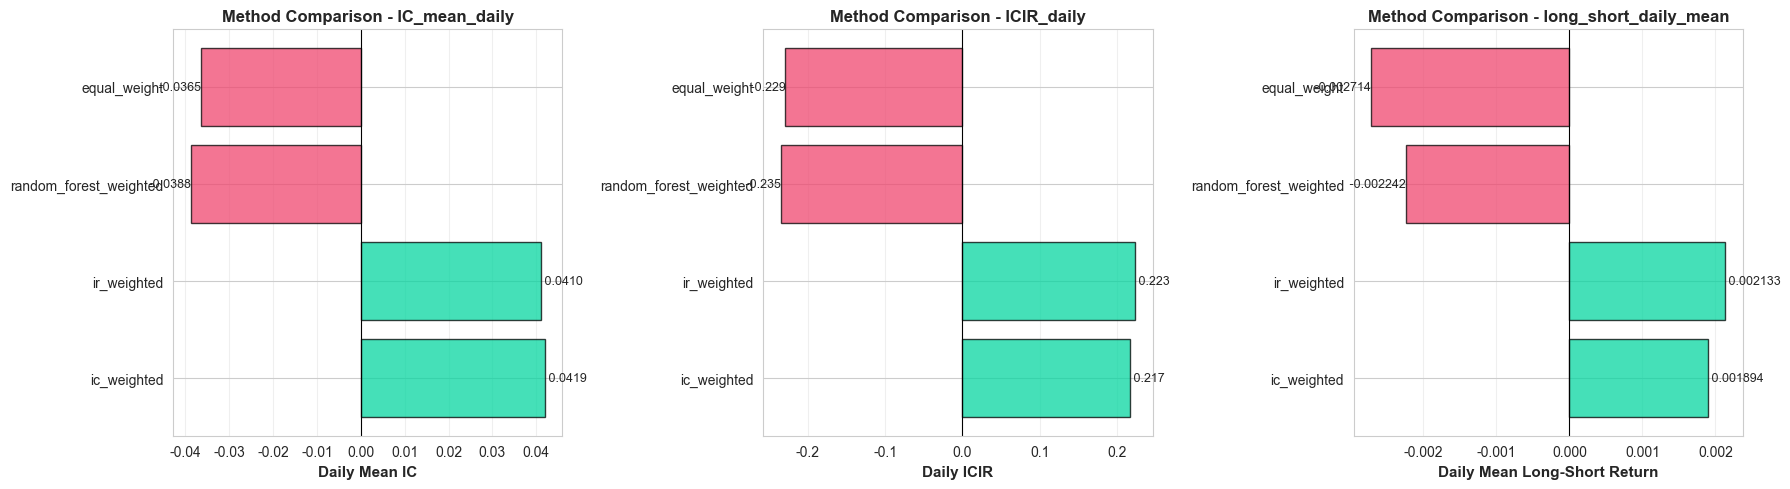


[图表 2] 因子权重分布


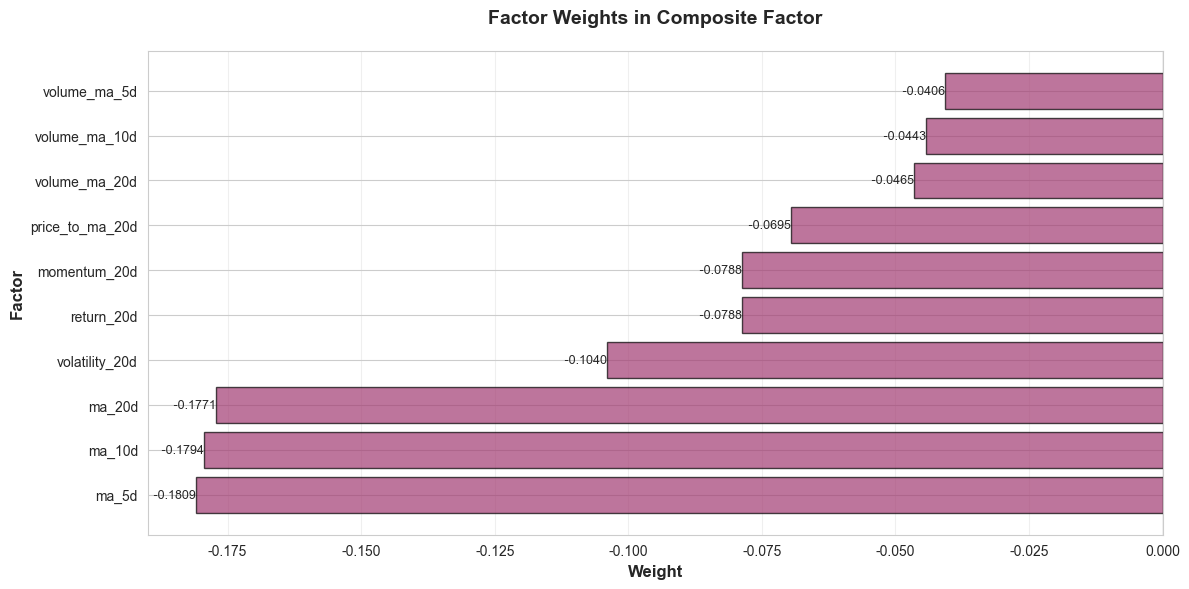


[图表 3] 因子相关性热力图


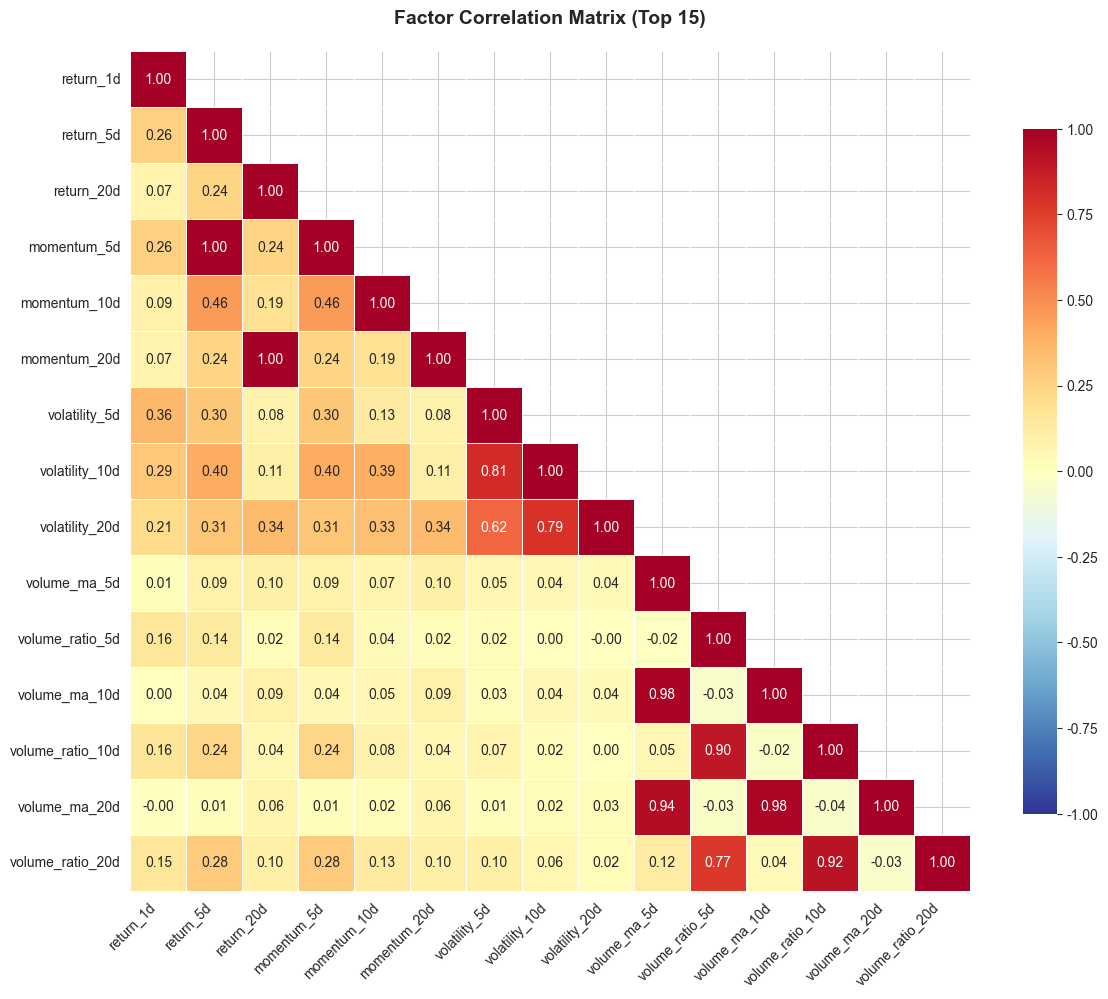


[图表 4] 合成因子IC时间序列


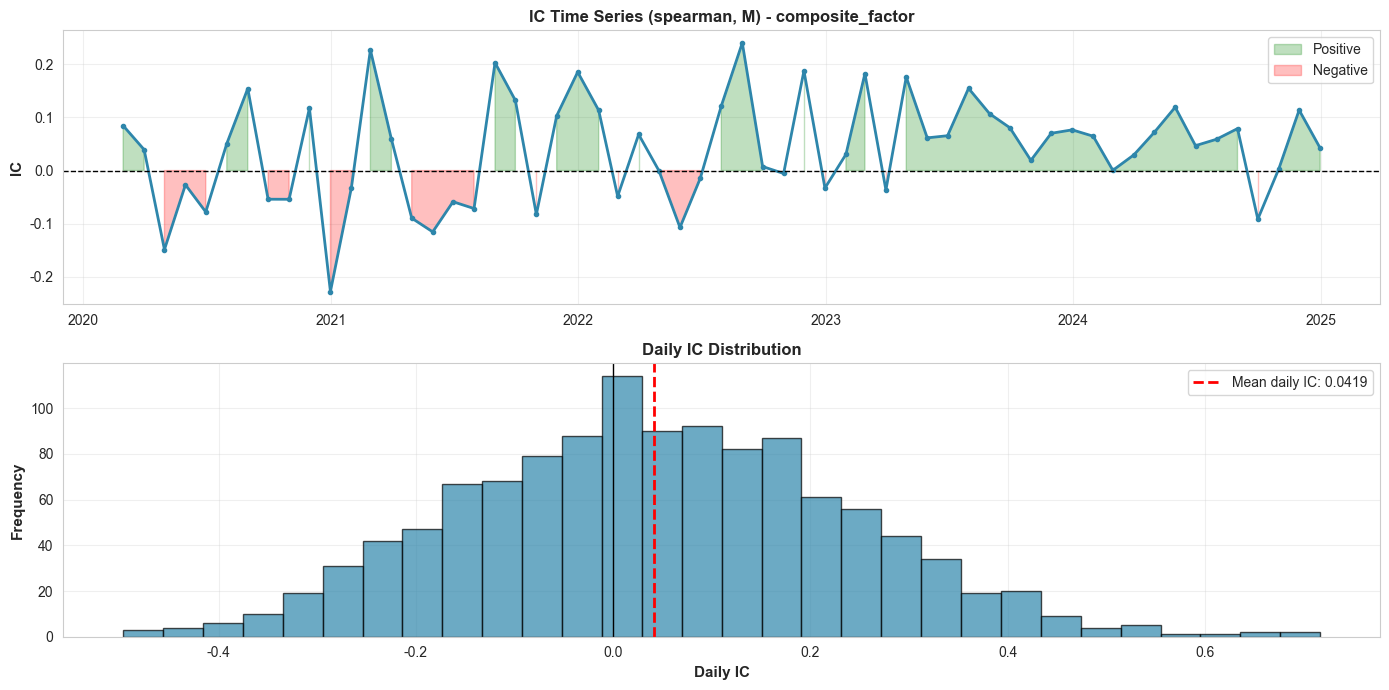


IC Statistics for composite_factor:
Daily Mean IC: 0.0419
Daily Std IC : 0.1932
Daily ICIR   : 0.217
IC Win Rate  : 58.30%
IC Days      : 1187

[图表 5] 回测结果


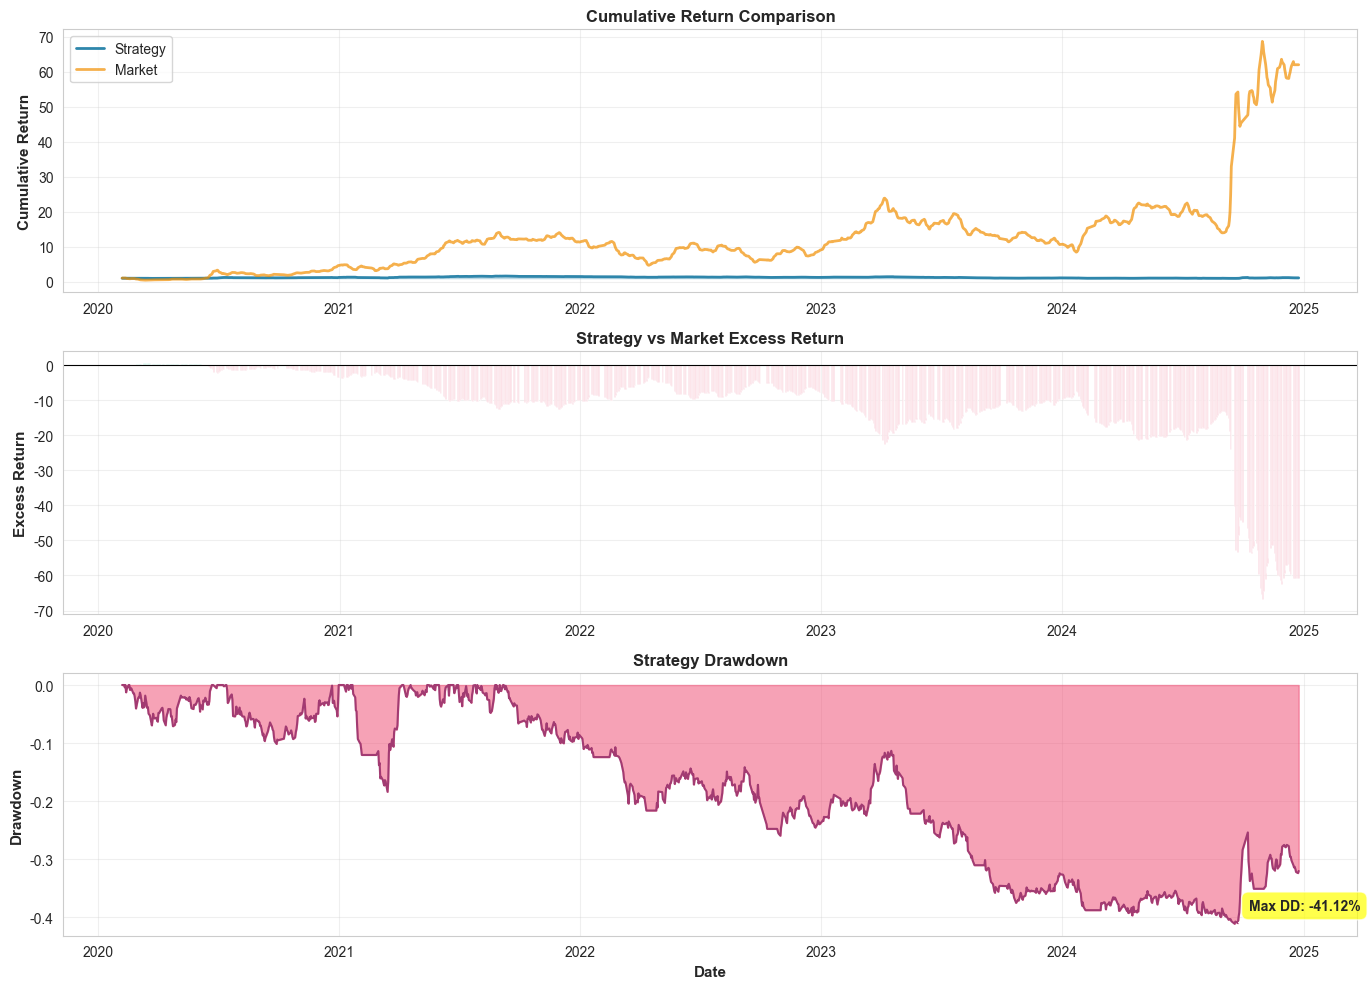


[图表 6] 合成因子分组表现（按日横截面分组）


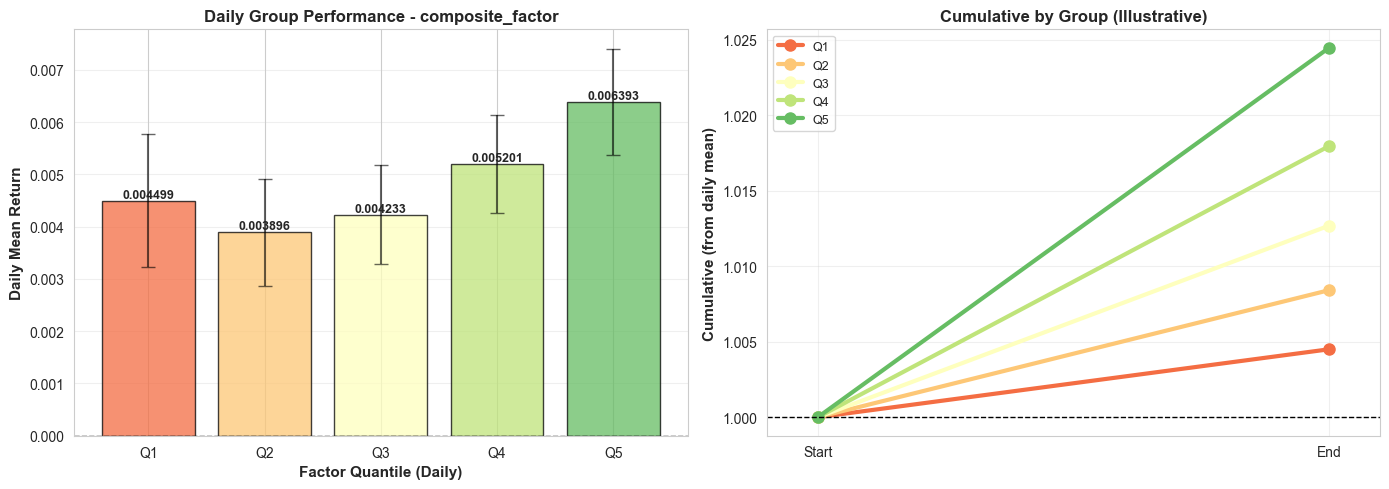


Long-Short Daily Mean Return: 0.001894
Group daily mean return:
Q1    0.004499
Q2    0.003896
Q3    0.004233
Q4    0.005201
Q5    0.006393
dtype: float64

所有可视化图表生成完成！

[图表 7] 性能指标雷达图


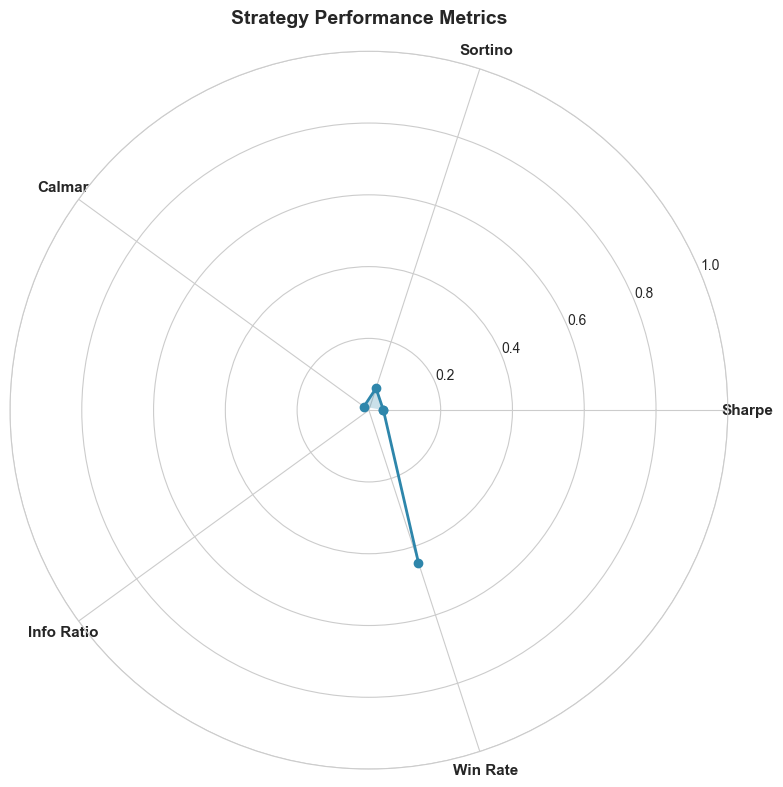


步骤 10/10: 生成策略报告

策略摘要报告

因子数量: 10
年化收益: 2.12%
夏普比率: 0.12
最大回撤: -41.12%
胜率: 44.7%
年化换手: 837.7次

策略评分: 0/10
策略评级: ★★☆☆☆ 需改进

建议:
- 考虑优化因子或调整仓位管理
- 建议加强风险控制，设置止损
- 换手率较高，注意交易成本
- 胜率偏低，建议重新评估因子有效性


In [12]:
if __name__ == "__main__":
    results = main(
        excel_path='沪深300成分股.xlsx',  # Excel文件路径
        start_date='20200101',             # 开始日期
        end_date='20241231',               # 结束日期
        enable_visualization=True,         # 是否生成图表
        enable_factor_screening=True,      # 是否筛选因子
        enable_risk_management=True,       # 是否风险管理
        model_type='xgboost'         # 模型类型
    )